

# <span style="color: #3498db;">CA2 - Genetic</span>

**<span style="color:rgb(247, 169, 0);">[AhmadReza Nopoush]</span> - <span style="color:rgb(26, 203, 20);">[610301194]</span>**



#### **<span style="color:rgb(223, 9, 84);">[Overview]</span>**

at this assignment, I want to approximate some functions with fourier series. I don't have any information of function criterion; I have just some points and the value of the function at those points. so by defining some genetic algorithms, I try to calculate the coefficients of fourier series. let's get into details!

#### **<span style="color:rgb(223, 9, 84);">[Initialization]</span>**

at the begining, we import 3 main libraries,
1. random: to generate random numbers
2. numpy: working with numpy arrays is more efficient
3. matplotlib: to plot!

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools

Now, with given function at below, we generate the sample we need to design our algorithm.

In [2]:
# These functions are given as samples to use in the algorithm
def getTargetFunction(functionName="sin_cos"):
    def sinCosFunction(t):
        """Target function: sin(2πt) + 0.5*cos(4πt)."""
        return np.sin(2 * np.pi * t) + 0.5 * np.cos(4 * np.pi * t)

    def linearFunction(t):
        """Simple linear function: y = 2t + 1."""
        return 2 * t + 1

    def quadraticFunction(t):
        """Quadratic function: y = 4t^2 - 4t + 2."""
        return 4 * (t**2) - 4 * t + 2

    def cubicFunction(t):
        """Cubic function: y = 8t^3 - 12t^2 + 6t."""
        return 8 * (t**3) - 12 * (t**2) + 6 * t

    def gaussianFunction(t):
        """Gaussian function centered at t=0.5."""
        mu = 0.5
        sigma = 0.1  # Adjust sigma to control the width of the peak
        return np.exp(-((t - mu) ** 2) / (2 * sigma**2))

    def squareWaveFunction(t):
        """Approximation of a square wave. Smoothed for better Fourier approximation."""
        return 0.5 * (np.sign(np.sin(2 * np.pi * t)) + 1)

    def sawtoothFunction(t):
        """Sawtooth wave, normalized to [0, 1]."""
        return (t * 5) % 1

    def complexFourierFunction(t):
        return (
            np.sin(2 * np.pi * t)
            + 0.3 * np.cos(4 * np.pi * t)
            + 0.2 * np.sin(6 * np.pi * t)
            + 0.1 * np.cos(8 * np.pi * t)
        )

    def polynomialFunction(t):
        return 10 * (t**5) - 20 * (t**4) + 15 * (t**3) - 4 * (t**2) + t + 0.5

    functionOptions = {
        "sin_cos": sinCosFunction,
        "linear": linearFunction,
        "quadratic": quadraticFunction,
        "cubic": cubicFunction,
        "gaussian": gaussianFunction,
        "square_wave": squareWaveFunction,
        "sawtooth": sawtoothFunction,
        "complex_fourier": complexFourierFunction,
        "polynomial": polynomialFunction,
    }

    selectedFunction = functionOptions.get(functionName.lower())
    if selectedFunction:
        return selectedFunction

As we can see at previous code, there is 9 function which we want to approximate with fourier Series. We can see a schema of the functions at below:

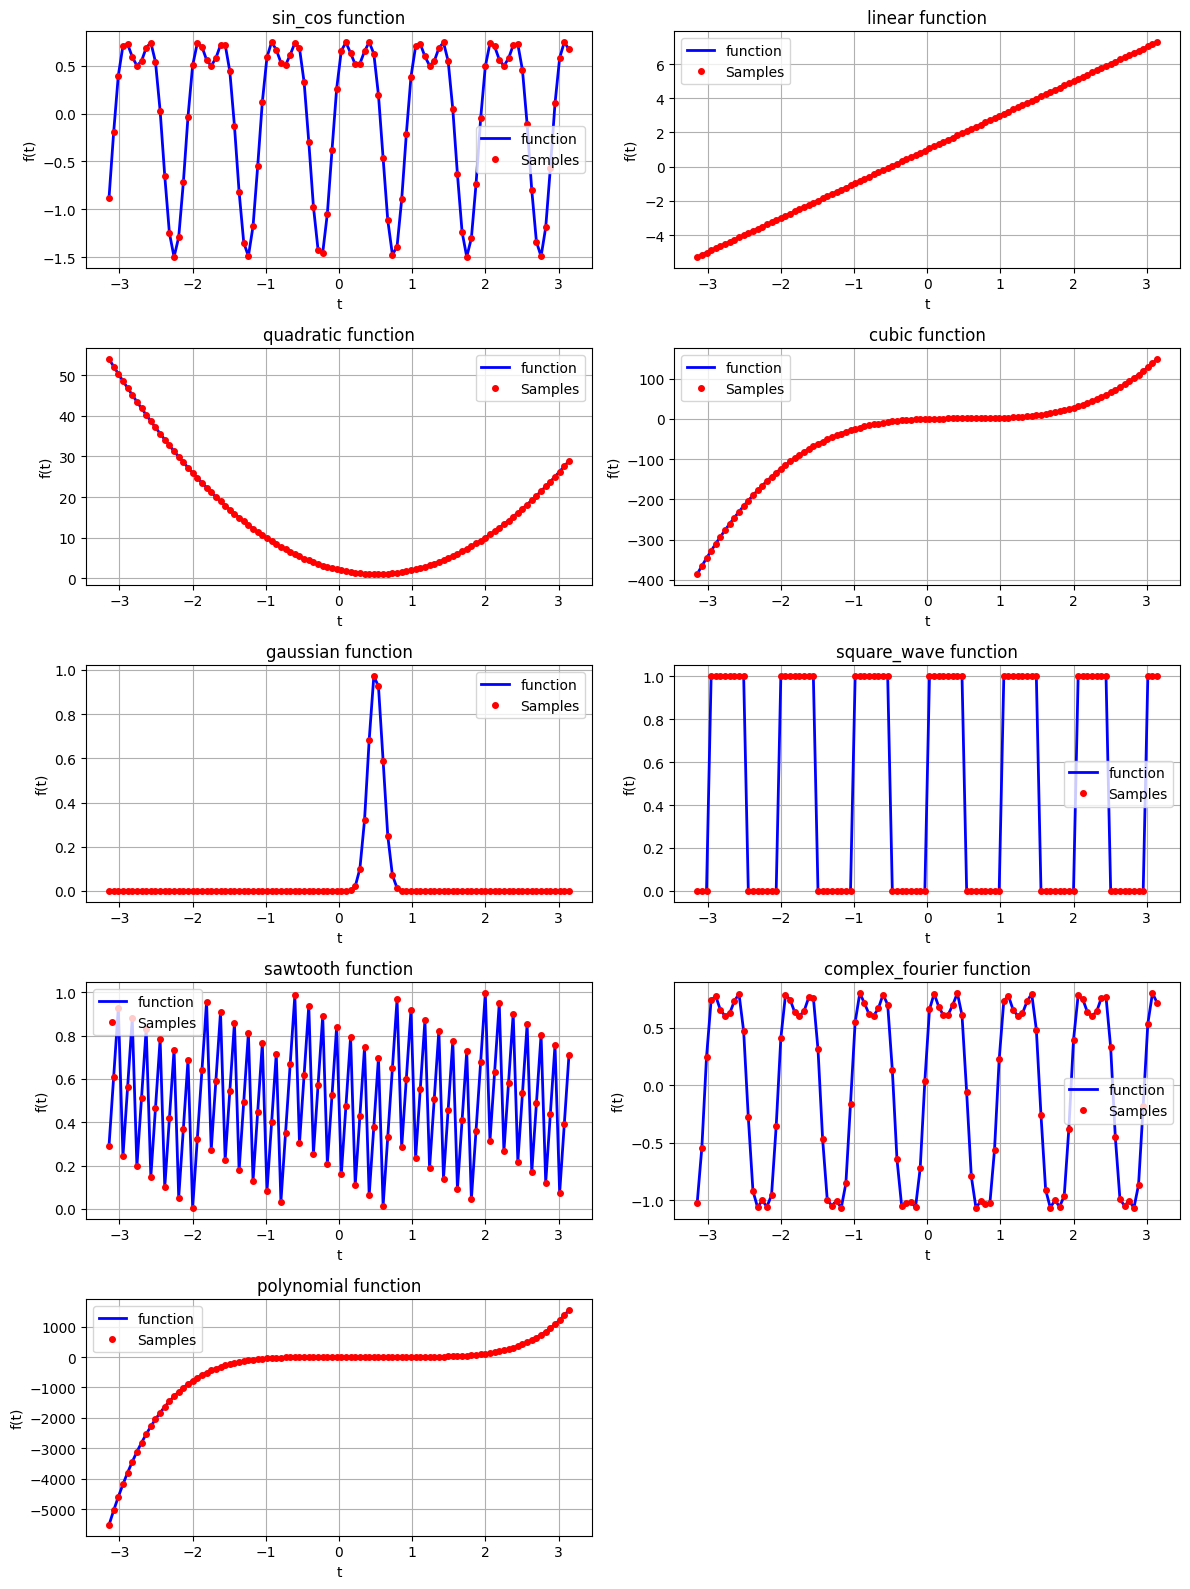

In [3]:
# Parameters
functionRange = (-np.pi, np.pi)
sampleCount = 100
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)

# Create figure with subplots
fig = plt.figure(figsize=(12, 16))
gs = GridSpec(5, 2, figure=fig)  # 5 rows, 2 columns

functionOptions = [ "sin_cos", "linear", "quadratic", "cubic", "gaussian",
                    "square_wave", "sawtooth", "complex_fourier", "polynomial"]


# Plot each function
i = 0
for opt in functionOptions:
    ax = fig.add_subplot(gs[i//2, i%2])
    i+=1
    
    # Calculate function values
    fSamples = getTargetFunction(functionName=opt)(tSamples)
    
    ax.plot(tSamples, fSamples, 'b-', label='function', linewidth=2)
    
    # Plot the samples
    ax.plot(tSamples, fSamples, 'ro', markersize=4, label='Samples')
    
    # Customize plot
    ax.set_title(f'{opt} function')
    ax.set_xlabel('t')
    ax.set_ylabel('f(t)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

**<span style="color:rgb(0, 211, 254);">[Note]</span>**

the blue line is the functions and the red points are samples. We want to find the coefficients of the Fourier series with the accuracy that is closest to the function (blue line).

#### **<span style="color:rgb(223, 9, 84);">[Defining Gene]</span>**

First and the most important queestion of genetic algorithm is how should we define gene(chromosome)? There might be several answers to this question, but I simply consider **Coefficients of fourier series** as gene.

the reason of my desicion is that the main thing that we want to achieve in this assignment is Coefficiens, and we have no information or even intuition of the values of coefficients. Second, genes in Genetic algorithm are constantly changing to reach the desired amount. So we can relate the genes and coefficients from this view of point.

I define the function ``CreateGene`` as below. It returns an np array of lenght  $  2N + 1  $   filled with random numbers in range $[-A, A]$ 

for the initial population, we can adopt various policies. for example, we can start from coefficients which generated from **uniform** or **normal** distribution. I choosed to generate population with **uniform** distribution; becuase the normal distribution values ​​most of the coefficients around the median, while the uniform distribution assigns equal probability to the entire range. Therefore, the uniform distribution produces a more diverse population for us.

In [4]:
def CreateGene(N:int, A:float):
    return np.random.uniform(low=-1*A, high=A, size=2*N+1)
        

**<span style="color:rgb(0, 211, 254);">[Fourier Serie]</span>**

at below, I define a function that returns an aproximatation of fourier serie with given coefficients. In other word, I implement
$$  f(x) \sim \frac{a_0}{2} + \sum_{i=1}^{N} \left[a_i \cos(ix) + b_i\sin(ix)\right] $$

In [5]:
def Fourier(Coefficients, x) -> float:
    length = (len(Coefficients)-1)//2
    sum = Coefficients[0]/2
    for i in range(1, length+1):
        sum += (Coefficients[i]*np.cos(i*x) + Coefficients[length+i]*np.sin(i*x))
    return sum

For ease of work, I store all the coefficients of $a_i$ and $b_i$ in an array and calculate the ``Fourier`` function based on that.

#### **<span style="color:rgb(223, 9, 84);">[Fitness Evaluation]</span>**

To understand how well the algorithm works, we need to find a metric to measure fitness. We know that the closer the ``Fourier`` is to the target function, the better and the gene(fourier serie coefficients) play main role in ``Fourier``. so our task is finding the best gene(coefficient) to approximate target function. and to measure the closure to target or goodness of our coefficients, **we need some metrics**

I introduce 3 metrics that we can use in ``Costfunction``. This function traverse whole sample, calculate the values of the ``Fourier`` serie approximation and the target value of each sample.

1. **Mean Squared Error (MSE):**
   $$ \text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - F(x_i))^2 $$

2. **Root Mean Squared Error (RMSE):**
   $$ \text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - F(x_i))^2} $$

3. **Mean Absolute Error (MAE):**
   $$ \text{MAE} = \frac{1}{n}\sum_{i=1}^{n}|y_i - F(x_i)| $$

Where:
- $y_i$ = Actual value of sample
- $F(x_i)$ = Fourier approximation in $x_i$ point
- $n$ = Number of samples


we will explain the effects, advantages and disadvantages of this metrics.

#### **<span style="color:rgb(223, 9, 84);">[Designing Algorithm]</span>**

Now, we reach the main part. There are four important components of the algorithm that we need to talk about.

**<span style="color:rgb(0, 211, 254);">[1. Crossover]</span>**

Crossover combines two genes and creates a new gene that inherits the desirable attributes of its two parent. In this problem case, we should try to generate a better coefficients from two parents as coefficients. There are several way and method to do Crossover.

1. **uniform:** Randomly picks each gene from either parent

2. **single point:** Chooses one random point and takes genes from the first parent up to that point, then from the second parent.

3. **two points:** Selects two random points and swaps the segment between them from the second parent.

**<span style="color:rgb(0, 211, 254);">[2. Mutation]</span>**

1. **Add:** Multiplies each coefficient by a small random value around 1 (like ±10% change).

2. **Random:** Randomly picks two coefficients and scales them with random factors.


**<span style="color:rgb(0, 211, 254);">[3. Selection]</span>**

we have many strategies to select parents from population. I implement 3 kind of selection:

1. **Tournament:** Randomly selects 3 individuals and chooses the best (lowest cost).

2. **Rank:** Ranks individuals by fitness and assigns selection probability accordingly.

3. **Roulette:** Selection probability is proportional to fitness (inverted cost).

#### **<span style="color:rgb(223, 9, 84);">[Implementation]</span>**

In [6]:
import numpy as np
from IPython.display import clear_output

class Algorithm:
    def __init__(self, tSamples, fSamples, numCoeffs:int, coeffRange:float, 
                 populationSize:int, generations:int, mutationRate:float):
        self.Population = [self.CreateGene(numCoeffs, coeffRange) for _ in range(populationSize)]
        self.Cost = [self.CostFunction(ind, tSamples, fSamples) for ind in self.Population]
        self.A = coeffRange
        self.tSamples = tSamples
        self.fSamples = fSamples
        self.PopulationSize = populationSize
        self.MutationRate = mutationRate
        self.Generations = generations
        self.NumCoeffs = numCoeffs
        self.BestCostHistory = []
        
    @staticmethod
    def CreateGene(N:int, A:float):
        """Create a random individual (set of Fourier coefficients)"""
        return np.random.uniform(low=-A, high=A, size=2*N+1)
    
    def CostFunction(self, Gene, tSamples, fSamples):
        """Calculate error between approximated and actual function"""
        approximated = np.array([self.Fourier(Gene, t) for t in tSamples])
        return np.sqrt(np.mean((approximated-fSamples)**2))
    
    @staticmethod
    def Fourier(Coefficients, x:float) -> float:
        """Evaluate Fourier series approximation at point x"""
        length = (len(Coefficients)-1)//2
        sum = Coefficients[0]/2
        for i in range(1, length+1):
            sum += (Coefficients[i]*np.cos(i*x) + Coefficients[length+i]*np.sin(i*x))
        return sum
    
    def Mutation(self, Gene, Mtype="add"):
        """Apply mutation to a gene"""
        mutated = Gene.copy()
        if Mtype == "add":
            if np.random.random() < self.MutationRate:
                for i in range(len(mutated)):
                    mutated[i] *= np.random.uniform(0.9,1.1)

        if Mtype == "random":
            if np.random.random() < self.MutationRate:
                idx1 = np.random.randint(0,len(Gene))
                idx2 = np.random.randint(0,len(Gene))
                mutated[idx1] *= (2*np.random.random())
                mutated[idx2] *= np.random.random()
        return mutated
    
    def Crossover(self, Parent1, Parent2, COtype="uniform"):
        """Create offspring through crossover"""
        child = np.zeros(len(Parent1))
        if COtype == "uniform":
            for i in range(len(Parent1)):
                child[i] = Parent1[i] if np.random.random() > 0.5 else Parent2[i]

        if COtype == "singlepoint":
            cdx = np.random.randint(1,len(Parent1)-2)
            for i in range(len(Parent1)):
                if i<=cdx:
                   child[i] = Parent1[i] 
                else:
                    child[i] = Parent2[i]

        if COtype == "twopoint":
            cdx1 = np.random.randint(1,len(Parent1))
            cdx2 = np.random.randint(0,cdx1)
            for i in range(len(Parent1)):
                if i<=cdx2 or i>cdx1:
                   child[i] = Parent1[i] 
                else:
                    child[i] = Parent2[i]
        return child
    
    def Selection(self,Stype="tournament"):
        if Stype == "tournament":
            selected_indices = np.random.choice(len(self.Population), size=3, replace=False)
            best_index = selected_indices[np.argmin([self.Cost[i] for i in selected_indices])]
            return self.Population[best_index]
        
        if Stype == "rank":
            sorted_indices = np.argsort(self.Cost)
            ranks = np.arange(len(self.Population))
            s = 1.5
            probabilities = (2 - s)/len(ranks) + 2*ranks*(s - 1)/(len(ranks)*(len(ranks) - 1))
            probabilities = probabilities[::-1]
            return self.Population[sorted_indices[np.random.choice(len(self.Population), p=probabilities)]]
        
        if Stype == "roulette":
            max_cost = max(self.Cost)
            fitness = [max_cost - cost + 1e-6 for cost in self.Cost]
            total_fitness = sum(fitness)
            probs = [f/total_fitness for f in fitness]
            return self.Population[np.random.choice(len(self.Population), p=probs)]
    
    def Run(self,printflag = True, COtype="random", Mtype="add",Stype="tournament"):
        """Run the genetic algorithm"""
        for gen in range(self.Generations):
            
            new_population = []
            new_costs = []
            
            best_idx = np.argmin(self.Cost)
            new_population.append(self.Population[best_idx].copy())
            new_costs.append(self.Cost[best_idx])
            
            while len(new_population) < self.PopulationSize:
                parent1 = self.Selection(Stype)
                parent2 = self.Selection(Stype)
                child = self.Crossover(parent1, parent2,COtype)
                child = self.Mutation(child,Mtype)
                
                new_population.append(child)
                new_costs.append(self.CostFunction(child, self.tSamples, self.fSamples))
            
            self.Population = new_population
            self.Cost = new_costs
            self.BestCostHistory.append(np.min(self.Cost))
            
            if printflag:
                clear_output(wait=True)
                print(f"Generation {gen+1}/{self.Generations}")
                print(f"Best RMSE: {self.BestCostHistory[-1]:.6f}")
                
        best_idx = np.argmin(self.Cost)
        return self.Population[best_idx], self.BestCostHistory

**<span style="color:rgb(223, 9, 84);">[Running Algorithm]</span>**

Generation 1/1
Best RMSE: 1.496392
best coefficents achieved:  [ 3.3877849   0.19750068 -4.78906014]


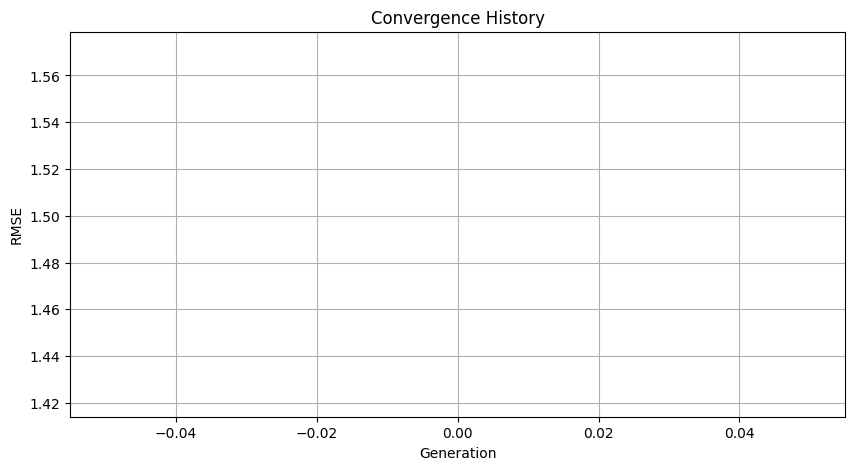

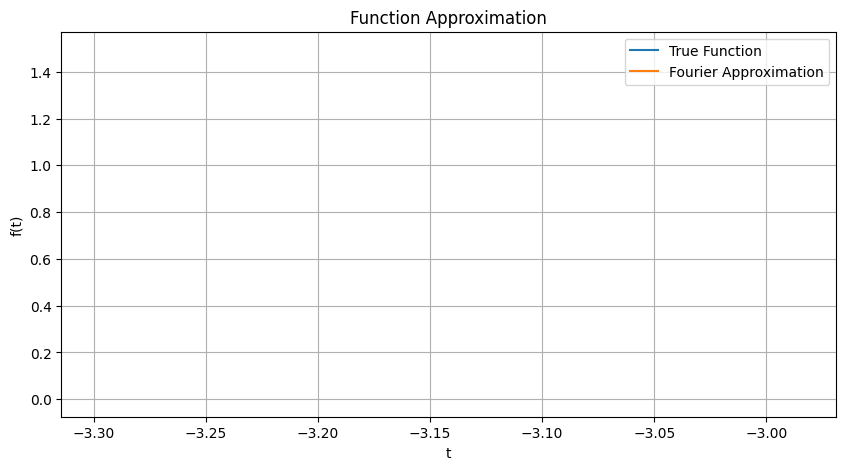

In [7]:
# algorithm parameters
numCoeffs = 1
populationSize = 1
generations = 1
mutationRate = 0.7
functionRange = (-np.pi, np.pi)
sampleCount = 1

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName="square_wave")(tSamples)

# Run genetic algorithm
ga = Algorithm(tSamples, fSamples, numCoeffs, 5, populationSize, generations, mutationRate)
best_coeffs, cost_history = ga.Run(COtype="uniform",Stype="tournament",Mtype="random")

print("best coefficents achieved: ", best_coeffs)
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Convergence History")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Plot function approximation
approx = [Fourier(best_coeffs, t) for t in tSamples]
plt.figure(figsize=(10, 5))
plt.plot(tSamples, fSamples, label='True Function')
plt.plot(tSamples, approx, label='Fourier Approximation')
plt.title("Function Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()



#### **<span style="color:rgb(223, 9, 84);">[Which combination?]</span>**

the question is, since we have $ 3 × 2 × 3 = 18 $ total combination of each crossover, mutation and selection policies, which combination should we choose? well a simple step to understand is that we run algorithm every choice.

**<span style="color:rgb(0, 211, 254);">[sin_cos]</span>**

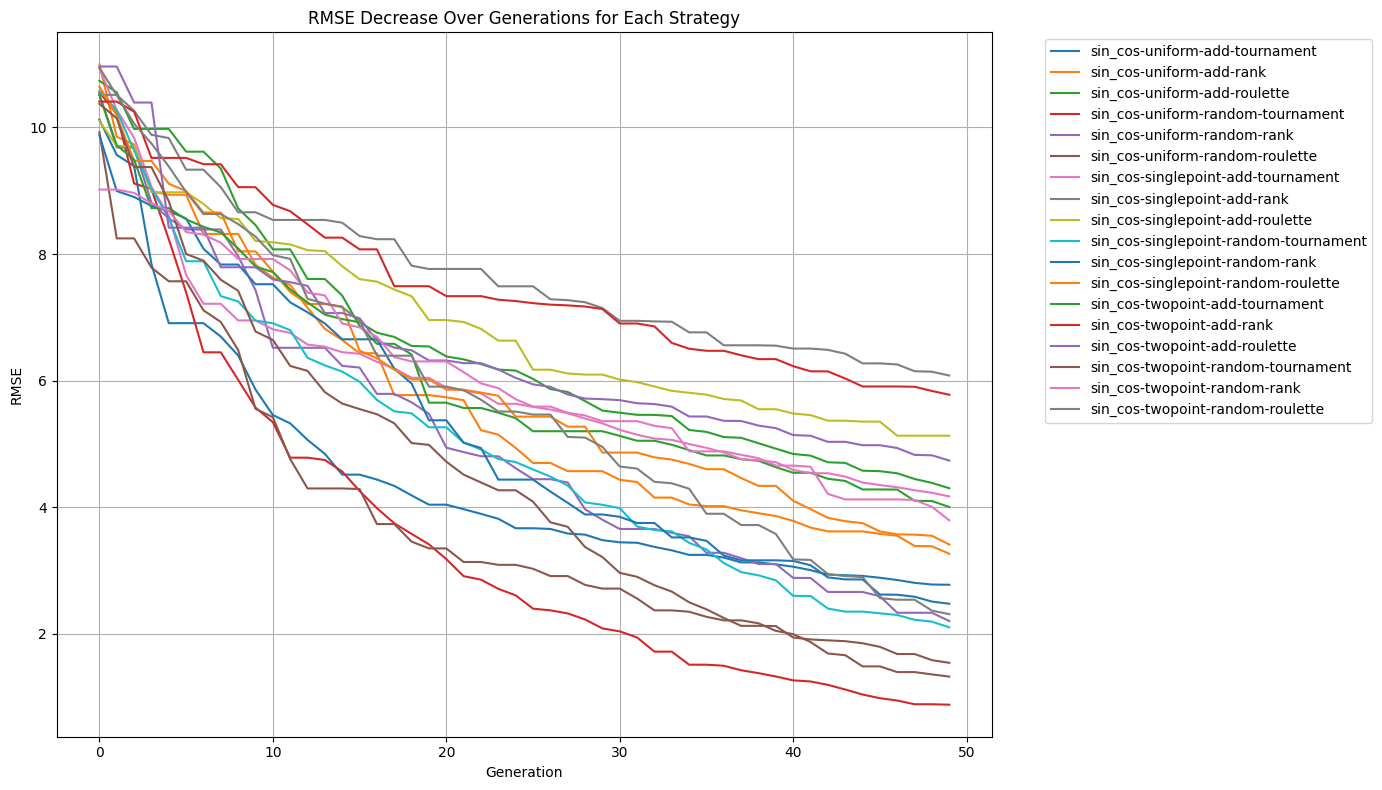

Best Configuration for  sin_cos : Crossover={best_config[0]}, Mutation={best_config[1]}, Selection={best_config[2]} with RMSE={best_config[3]:.6f}


In [8]:
crossover_types = ['uniform', 'singlepoint', 'twopoint']
mutation_types = ['add', 'random']
selection_types = ['tournament', 'rank', 'roulette']

f = "sin_cos"

histories = []
labels = []
results = []
    # algorithm parameters
numCoeffs = 20
    
populationSize = 50
generations = 50
mutationRate = 0.3
functionRange = (-np.pi, np.pi)
sampleCount = 100

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName=f)(tSamples)

for CO, M, S in itertools.product(crossover_types, mutation_types, selection_types):
    alg = Algorithm(tSamples, fSamples, numCoeffs, coeffRange=5,
            populationSize=populationSize, generations=generations, mutationRate=mutationRate)
    best, history = alg.Run(printflag=False,COtype=CO, Mtype=M, Stype=S)
    histories.append(history)
    labels.append(f"{f}-{CO}-{M}-{S}")
    results.append((CO, M, S, history[-1]))

plt.figure(figsize=(14,8))
for i, history in enumerate(histories):
    plt.plot(history, label=labels[i])
        
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.title("RMSE Decrease Over Generations for Each Strategy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.tight_layout()
plt.grid(True)
plt.show()

# Best policy
best_config = min(results, key=lambda x: x[3])
print(f"Best Configuration for ",f,": Crossover={best_config[0]}, Mutation={best_config[1]}, Selection={best_config[2]} with RMSE={best_config[3]:.6f}")

**<span style="color:rgb(0, 211, 254);">[linear]</span>**

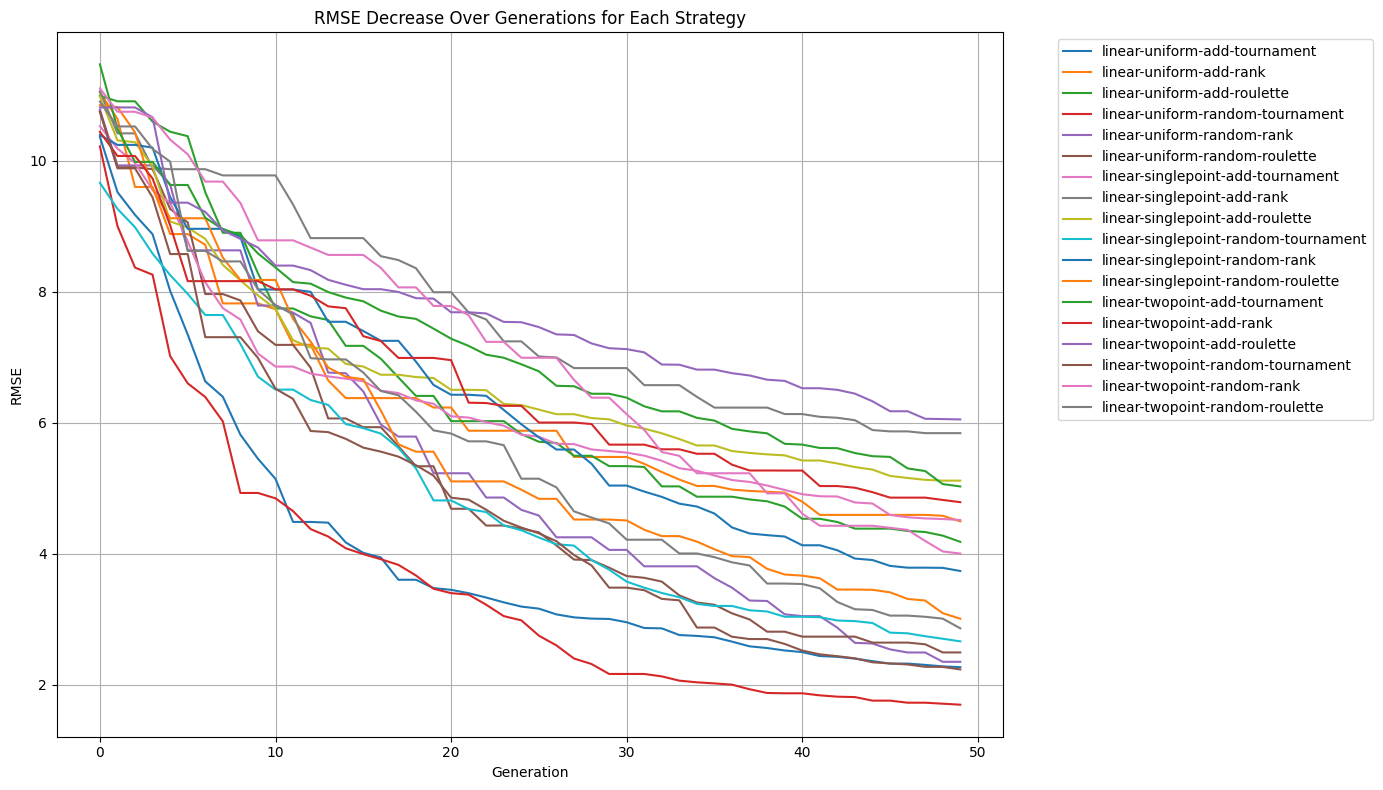

Best Configuration for  linear : Crossover={best_config[0]}, Mutation={best_config[1]}, Selection={best_config[2]} with RMSE={best_config[3]:.6f}


In [9]:
crossover_types = ['uniform', 'singlepoint', 'twopoint']
mutation_types = ['add', 'random']
selection_types = ['tournament', 'rank', 'roulette']

f = "linear"

histories = []
labels = []
results = []
    # algorithm parameters
numCoeffs = 20
    
populationSize = 50
generations = 50
mutationRate = 0.3
functionRange = (-np.pi, np.pi)
sampleCount = 100

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName=f)(tSamples)

for CO, M, S in itertools.product(crossover_types, mutation_types, selection_types):
    alg = Algorithm(tSamples, fSamples, numCoeffs, coeffRange=5,
            populationSize=populationSize, generations=generations, mutationRate=mutationRate)
    best, history = alg.Run(printflag=False,COtype=CO, Mtype=M, Stype=S)
    histories.append(history)
    labels.append(f"{f}-{CO}-{M}-{S}")
    results.append((CO, M, S, history[-1]))

plt.figure(figsize=(14,8))
for i, history in enumerate(histories):
    plt.plot(history, label=labels[i])
        
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.title("RMSE Decrease Over Generations for Each Strategy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.tight_layout()
plt.grid(True)
plt.show()

# Best policy
best_config = min(results, key=lambda x: x[3])
print(f"Best Configuration for ",f,": Crossover={best_config[0]}, Mutation={best_config[1]}, Selection={best_config[2]} with RMSE={best_config[3]:.6f}")

**<span style="color:rgb(0, 211, 254);">[quadratic]</span>**

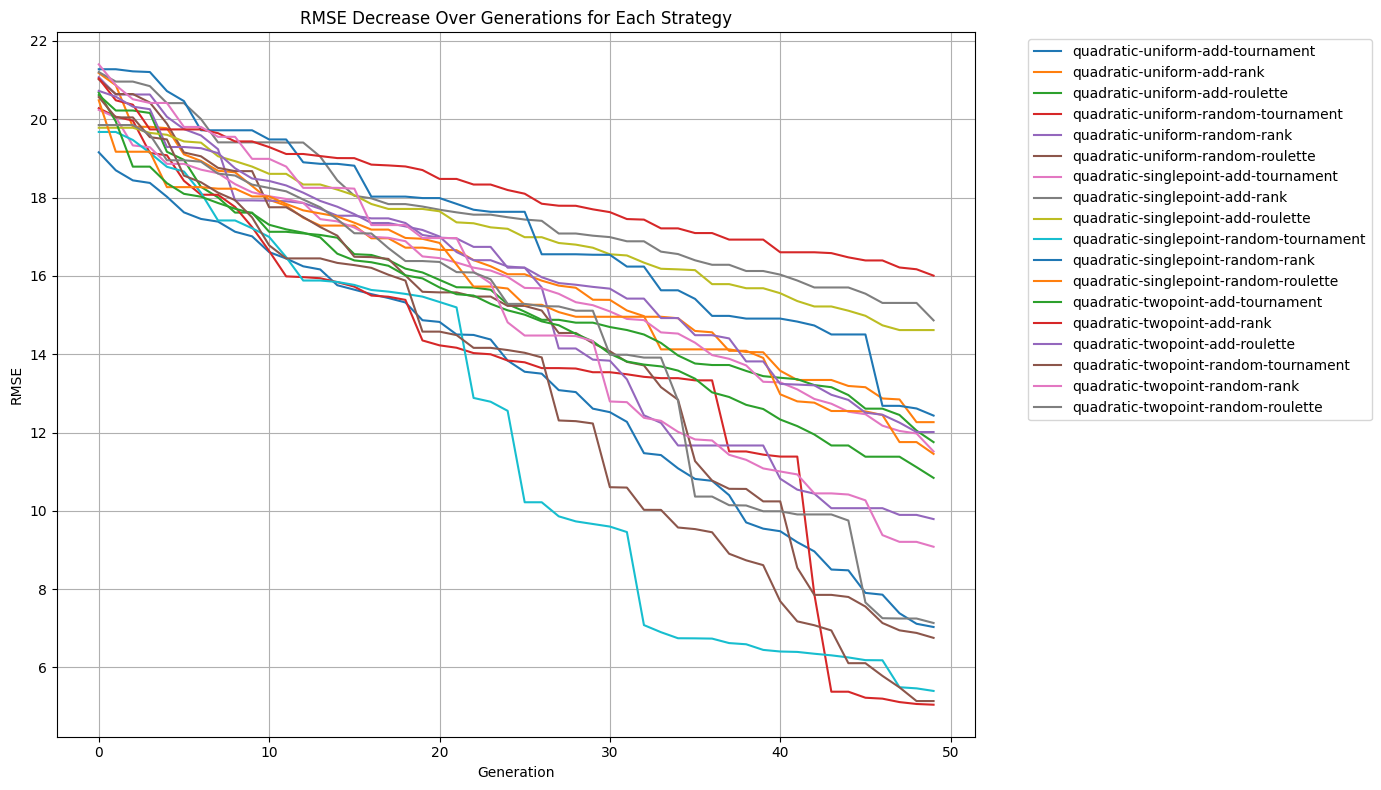

Best Configuration for  quadratic : Crossover=uniform, Mutation=random, Selection=tournament with RMSE=5.050000


In [10]:
crossover_types = ['uniform', 'singlepoint', 'twopoint']
mutation_types = ['add', 'random']
selection_types = ['tournament', 'rank', 'roulette']

f = "quadratic"

histories = []
labels = []
results = []
    # algorithm parameters
numCoeffs = 20
    
populationSize = 50
generations = 50
mutationRate = 0.3
functionRange = (-np.pi, np.pi)
sampleCount = 100

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName=f)(tSamples)

for CO, M, S in itertools.product(crossover_types, mutation_types, selection_types):
    alg = Algorithm(tSamples, fSamples, numCoeffs, coeffRange=5,
            populationSize=populationSize, generations=generations, mutationRate=mutationRate)
    best, history = alg.Run(printflag=False,COtype=CO, Mtype=M, Stype=S)
    histories.append(history)
    labels.append(f"{f}-{CO}-{M}-{S}")
    results.append((CO, M, S, history[-1]))

plt.figure(figsize=(14,8))
for i, history in enumerate(histories):
    plt.plot(history, label=labels[i])
        
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.title("RMSE Decrease Over Generations for Each Strategy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.tight_layout()
plt.grid(True)
plt.show()

# Best policy
best_config = min(results, key=lambda x: x[3])
print(f"Best Configuration for ",f,f": Crossover={best_config[0]}, Mutation={best_config[1]}, Selection={best_config[2]} with RMSE={best_config[3]:.6f}")

**<span style="color:rgb(0, 211, 254);">[cubic]</span>**

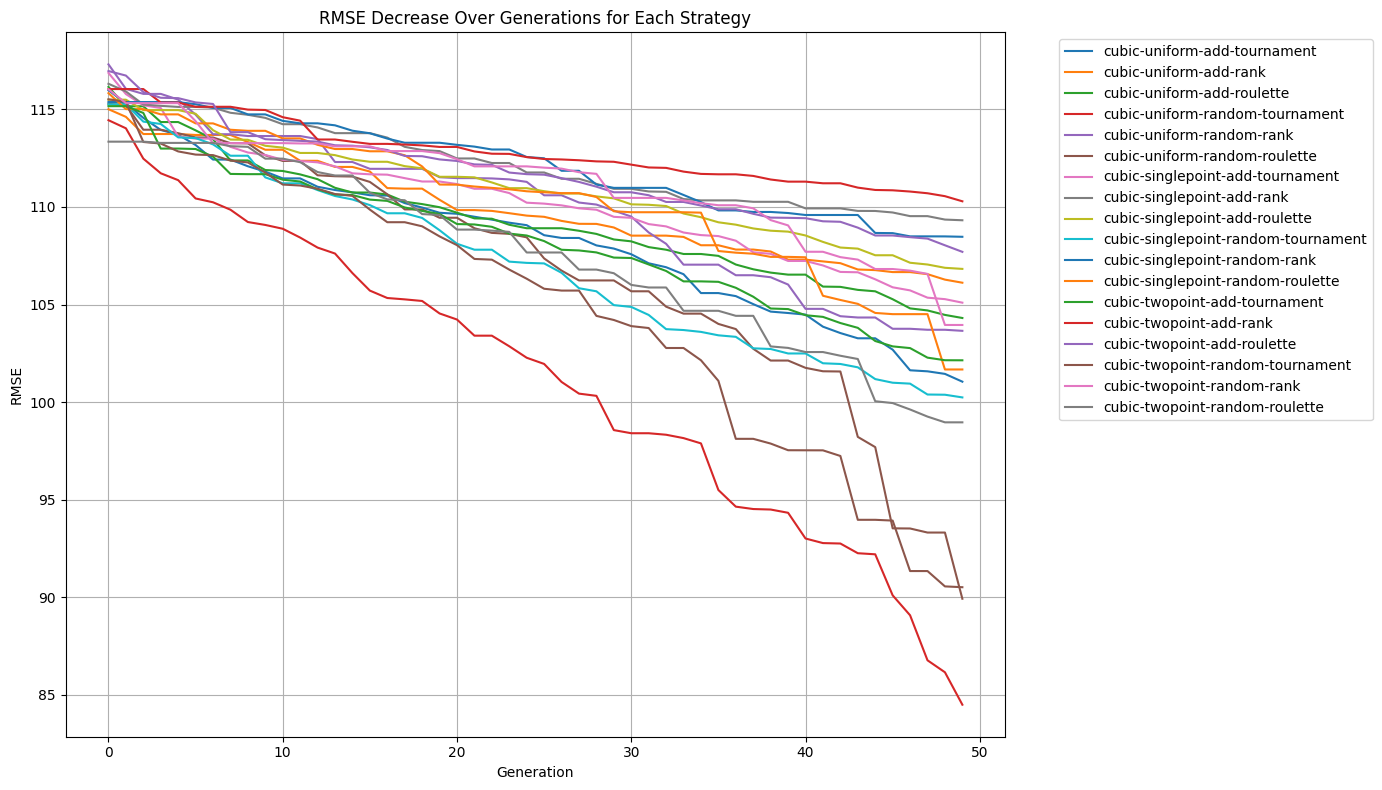

Best Configuration for  cubic : Crossover=uniform, Mutation=random, Selection=tournament with RMSE=84.494120


In [11]:
crossover_types = ['uniform', 'singlepoint', 'twopoint']
mutation_types = ['add', 'random']
selection_types = ['tournament', 'rank', 'roulette']

f = "cubic"

histories = []
labels = []
results = []
    # algorithm parameters
numCoeffs = 20
    
populationSize = 50
generations = 50
mutationRate = 0.3
functionRange = (-np.pi, np.pi)
sampleCount = 100

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName=f)(tSamples)

for CO, M, S in itertools.product(crossover_types, mutation_types, selection_types):
    alg = Algorithm(tSamples, fSamples, numCoeffs, coeffRange=5,
            populationSize=populationSize, generations=generations, mutationRate=mutationRate)
    best, history = alg.Run(printflag=False,COtype=CO, Mtype=M, Stype=S)
    histories.append(history)
    labels.append(f"{f}-{CO}-{M}-{S}")
    results.append((CO, M, S, history[-1]))

plt.figure(figsize=(14,8))
for i, history in enumerate(histories):
    plt.plot(history, label=labels[i])
        
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.title("RMSE Decrease Over Generations for Each Strategy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.tight_layout()
plt.grid(True)
plt.show()

# Best policy
best_config = min(results, key=lambda x: x[3])
print(f"Best Configuration for ",f,f": Crossover={best_config[0]}, Mutation={best_config[1]}, Selection={best_config[2]} with RMSE={best_config[3]:.6f}")

**<span style="color:rgb(0, 211, 254);">[gaussian]</span>**

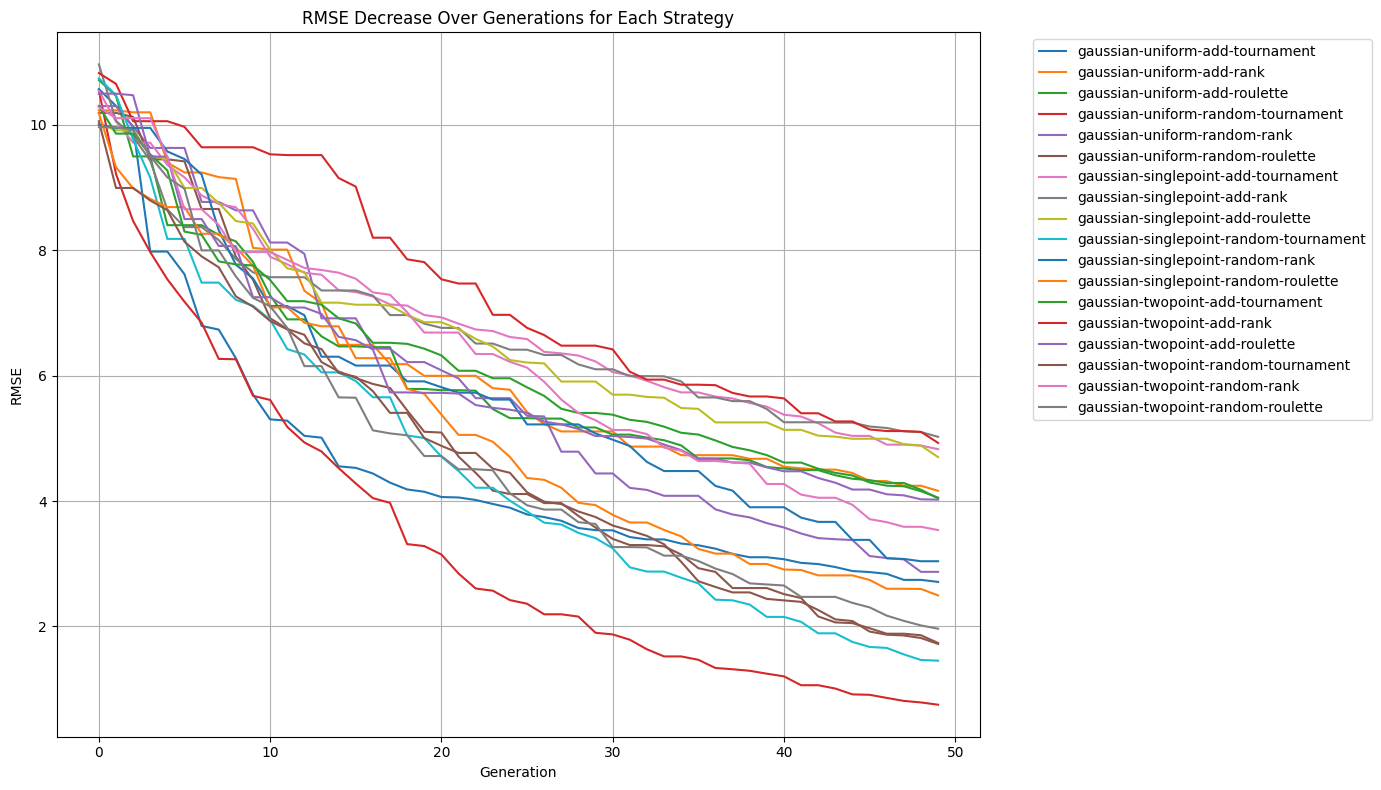

Best Configuration for  gaussian : Crossover=uniform, Mutation=random, Selection=tournament with RMSE=0.752186


In [12]:
crossover_types = ['uniform', 'singlepoint', 'twopoint']
mutation_types = ['add', 'random']
selection_types = ['tournament', 'rank', 'roulette']

f = "gaussian"

histories = []
labels = []
results = []
    # algorithm parameters
numCoeffs = 20
    
populationSize = 50
generations = 50
mutationRate = 0.3
functionRange = (-np.pi, np.pi)
sampleCount = 100

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName=f)(tSamples)

for CO, M, S in itertools.product(crossover_types, mutation_types, selection_types):
    alg = Algorithm(tSamples, fSamples, numCoeffs, coeffRange=5,
            populationSize=populationSize, generations=generations, mutationRate=mutationRate)
    best, history = alg.Run(printflag=False,COtype=CO, Mtype=M, Stype=S)
    histories.append(history)
    labels.append(f"{f}-{CO}-{M}-{S}")
    results.append((CO, M, S, history[-1]))

plt.figure(figsize=(14,8))
for i, history in enumerate(histories):
    plt.plot(history, label=labels[i])
        
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.title("RMSE Decrease Over Generations for Each Strategy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.tight_layout()
plt.grid(True)
plt.show()

# Best policy
best_config = min(results, key=lambda x: x[3])
print(f"Best Configuration for ",f,f": Crossover={best_config[0]}, Mutation={best_config[1]}, Selection={best_config[2]} with RMSE={best_config[3]:.6f}")

**<span style="color:rgb(0, 211, 254);">[square_wave]</span>**

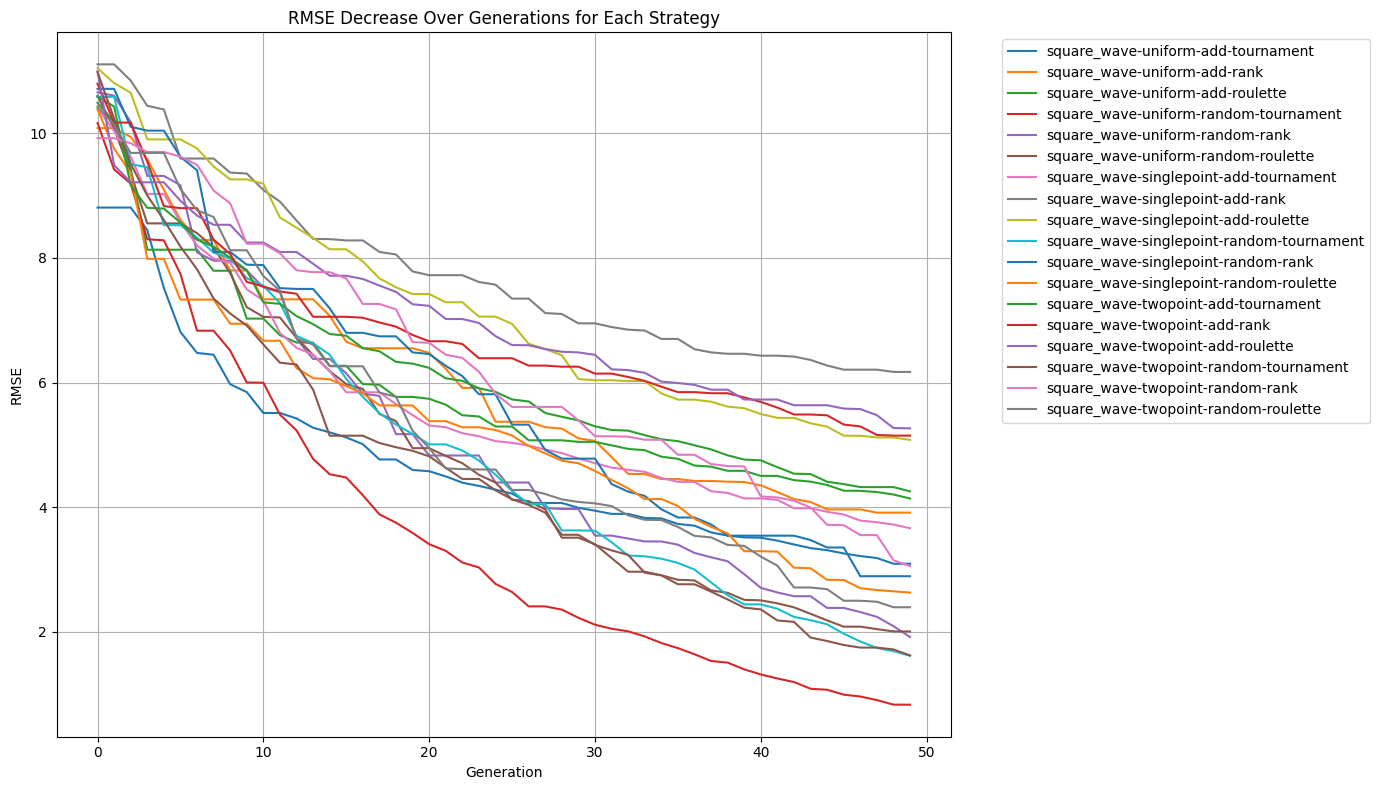

Best Configuration for  square_wave : Crossover=uniform, Mutation=random, Selection=tournament with RMSE=0.833647


In [13]:
crossover_types = ['uniform', 'singlepoint', 'twopoint']
mutation_types = ['add', 'random']
selection_types = ['tournament', 'rank', 'roulette']

f = "square_wave"

histories = []
labels = []
results = []
    # algorithm parameters
numCoeffs = 20
    
populationSize = 50
generations = 50
mutationRate = 0.3
functionRange = (-np.pi, np.pi)
sampleCount = 100

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName=f)(tSamples)

for CO, M, S in itertools.product(crossover_types, mutation_types, selection_types):
    alg = Algorithm(tSamples, fSamples, numCoeffs, coeffRange=5,
            populationSize=populationSize, generations=generations, mutationRate=mutationRate)
    best, history = alg.Run(printflag=False,COtype=CO, Mtype=M, Stype=S)
    histories.append(history)
    labels.append(f"{f}-{CO}-{M}-{S}")
    results.append((CO, M, S, history[-1]))

plt.figure(figsize=(14,8))
for i, history in enumerate(histories):
    plt.plot(history, label=labels[i])
        
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.title("RMSE Decrease Over Generations for Each Strategy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.tight_layout()
plt.grid(True)
plt.show()

# Best policy
best_config = min(results, key=lambda x: x[3])
print(f"Best Configuration for ",f,f": Crossover={best_config[0]}, Mutation={best_config[1]}, Selection={best_config[2]} with RMSE={best_config[3]:.6f}")

**<span style="color:rgb(0, 211, 254);">[sawtooth]</span>**

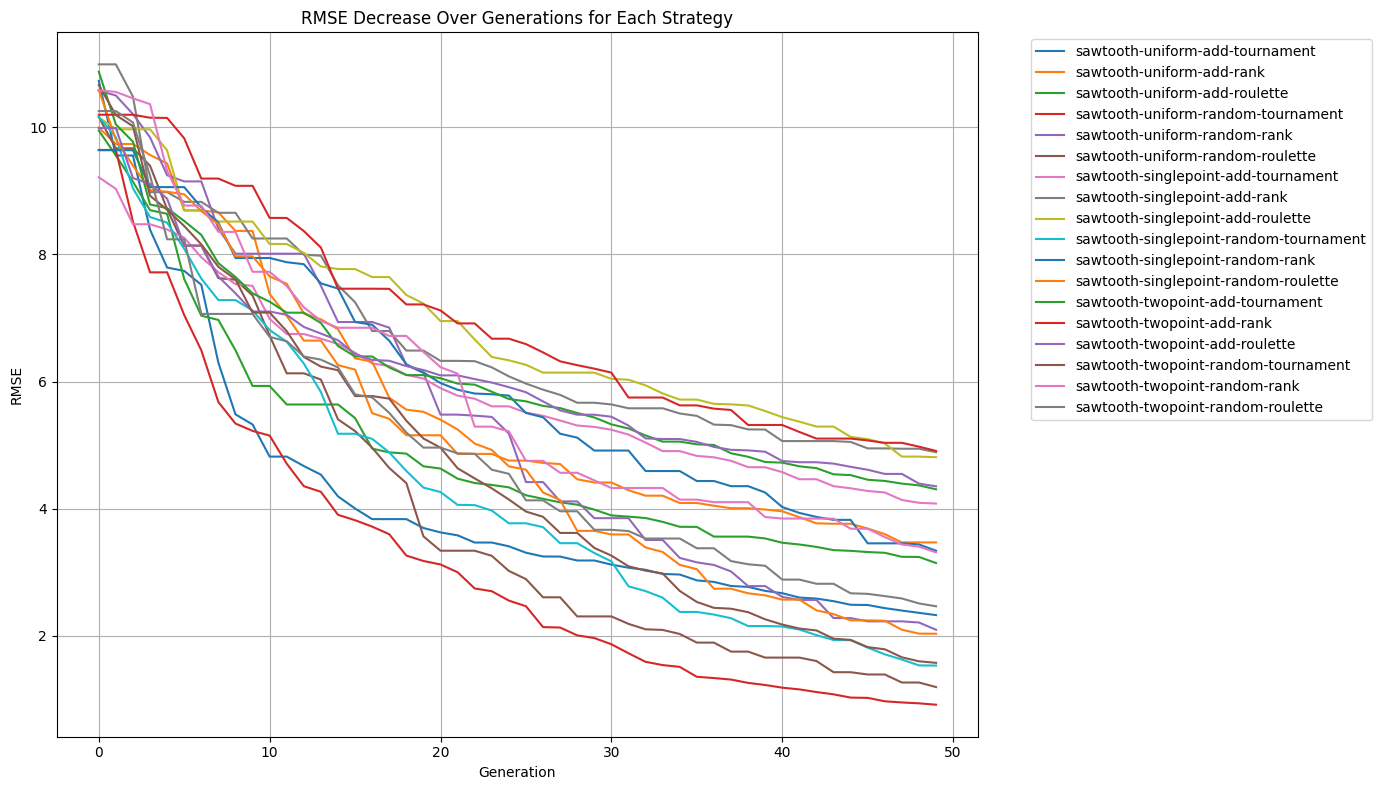

Best Configuration for  sawtooth : Crossover=uniform, Mutation=random, Selection=tournament with RMSE=0.916973


In [14]:
crossover_types = ['uniform', 'singlepoint', 'twopoint']
mutation_types = ['add', 'random']
selection_types = ['tournament', 'rank', 'roulette']

f = "sawtooth"

histories = []
labels = []
results = []
    # algorithm parameters
numCoeffs = 20
    
populationSize = 50
generations = 50
mutationRate = 0.3
functionRange = (-np.pi, np.pi)
sampleCount = 100

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName=f)(tSamples)

for CO, M, S in itertools.product(crossover_types, mutation_types, selection_types):
    alg = Algorithm(tSamples, fSamples, numCoeffs, coeffRange=5,
            populationSize=populationSize, generations=generations, mutationRate=mutationRate)
    best, history = alg.Run(printflag=False,COtype=CO, Mtype=M, Stype=S)
    histories.append(history)
    labels.append(f"{f}-{CO}-{M}-{S}")
    results.append((CO, M, S, history[-1]))

plt.figure(figsize=(14,8))
for i, history in enumerate(histories):
    plt.plot(history, label=labels[i])
        
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.title("RMSE Decrease Over Generations for Each Strategy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.tight_layout()
plt.grid(True)
plt.show()

# Best policy
best_config = min(results, key=lambda x: x[3])
print(f"Best Configuration for ",f,f": Crossover={best_config[0]}, Mutation={best_config[1]}, Selection={best_config[2]} with RMSE={best_config[3]:.6f}")

**<span style="color:rgb(0, 211, 254);">[complex_fourier]</span>**

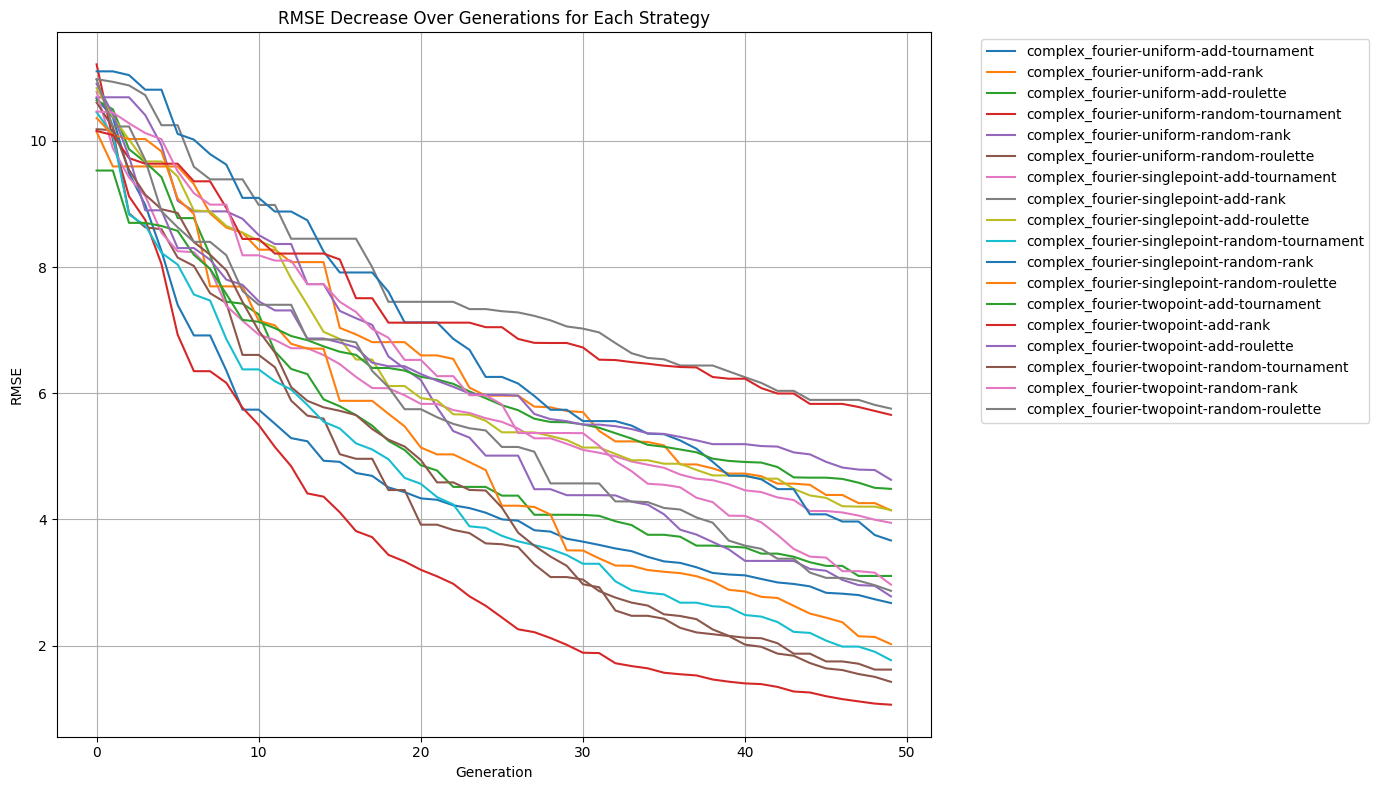

Best Configuration for  complex_fourier : Crossover=uniform, Mutation=random, Selection=tournament with RMSE=1.063546


In [15]:
crossover_types = ['uniform', 'singlepoint', 'twopoint']
mutation_types = ['add', 'random']
selection_types = ['tournament', 'rank', 'roulette']

f = "complex_fourier"

histories = []
labels = []
results = []
    # algorithm parameters
numCoeffs = 20
    
populationSize = 50
generations = 50
mutationRate = 0.3
functionRange = (-np.pi, np.pi)
sampleCount = 100

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName=f)(tSamples)

for CO, M, S in itertools.product(crossover_types, mutation_types, selection_types):
    alg = Algorithm(tSamples, fSamples, numCoeffs, coeffRange=5,
            populationSize=populationSize, generations=generations, mutationRate=mutationRate)
    best, history = alg.Run(printflag=False,COtype=CO, Mtype=M, Stype=S)
    histories.append(history)
    labels.append(f"{f}-{CO}-{M}-{S}")
    results.append((CO, M, S, history[-1]))

plt.figure(figsize=(14,8))
for i, history in enumerate(histories):
    plt.plot(history, label=labels[i])
        
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.title("RMSE Decrease Over Generations for Each Strategy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.tight_layout()
plt.grid(True)
plt.show()

# Best policy
best_config = min(results, key=lambda x: x[3])
print(f"Best Configuration for ",f,f": Crossover={best_config[0]}, Mutation={best_config[1]}, Selection={best_config[2]} with RMSE={best_config[3]:.6f}")

**<span style="color:rgb(0, 211, 254);">[polynomial]</span>**

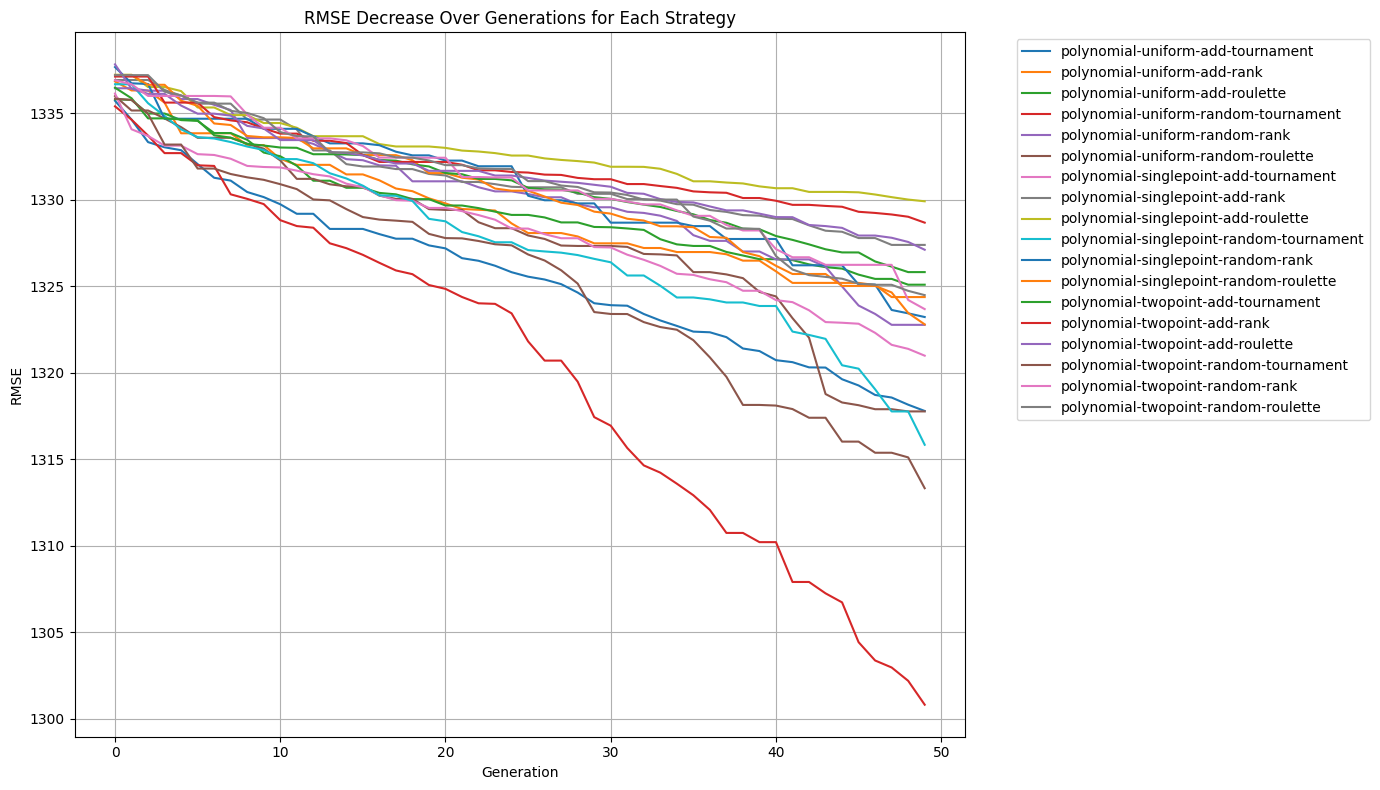

Best Configuration for  polynomial : Crossover=uniform, Mutation=random, Selection=tournament with RMSE=1300.821622


In [16]:
crossover_types = ['uniform', 'singlepoint', 'twopoint']
mutation_types = ['add', 'random']
selection_types = ['tournament', 'rank', 'roulette']

f = "polynomial"

histories = []
labels = []
results = []
    # algorithm parameters
numCoeffs = 20
    
populationSize = 50
generations = 50
mutationRate = 0.3
functionRange = (-np.pi, np.pi)
sampleCount = 100

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName=f)(tSamples)

for CO, M, S in itertools.product(crossover_types, mutation_types, selection_types):
    alg = Algorithm(tSamples, fSamples, numCoeffs, coeffRange=5,
            populationSize=populationSize, generations=generations, mutationRate=mutationRate)
    best, history = alg.Run(printflag=False,COtype=CO, Mtype=M, Stype=S)
    histories.append(history)
    labels.append(f"{f}-{CO}-{M}-{S}")
    results.append((CO, M, S, history[-1]))

plt.figure(figsize=(14,8))
for i, history in enumerate(histories):
    plt.plot(history, label=labels[i])
        
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.title("RMSE Decrease Over Generations for Each Strategy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.tight_layout()
plt.grid(True)
plt.show()

# Best policy
best_config = min(results, key=lambda x: x[3])
print(f"Best Configuration for ",f,f": Crossover={best_config[0]}, Mutation={best_config[1]}, Selection={best_config[2]} with RMSE={best_config[3]:.6f}")

**<span style="color:rgb(0, 211, 254);">[Result]</span>**
as we can see, the combination of **uniform** for *Crossover*, **random** for *Mutation* and **tournament** for *Selection* is the winner combination!

#### **<span style="color:rgb(223, 9, 84);">[Final Run]</span>**


**<span style="color:rgb(0, 211, 254);">[sin_cos]</span>**

Generation 100/100
Best RMSE: 0.187356
best coefficents achieved:  [-2.03795993e-04  2.29207365e-03  3.81826092e-02  1.36268045e-03
  2.57182947e-02  3.73219835e-04  1.76374244e-02 -2.77275827e-02
 -8.04031004e-04 -4.77391717e-02  7.14650642e-02 -1.00831441e-01
  2.48662469e-01  3.46622498e-01 -9.35772572e-02  4.87963667e-02
 -3.86087109e-02 -4.12156418e-04 -3.08050821e-02 -1.49694320e-03
 -1.09448440e-03 -6.48156260e-03  2.20315596e-02  2.17921386e-03
 -5.82692816e-04 -3.75879989e-02  8.63704562e-01  3.29577369e-01
 -1.55535550e-01  1.00867979e-01 -1.00064022e-01 -5.26644031e-04
  2.36152829e-04 -3.44755923e-03 -3.10712709e-02  4.35368863e-02
 -4.57288771e-02  2.88769037e-02 -2.37514067e-02 -1.21564441e-03
  2.32018999e-03]


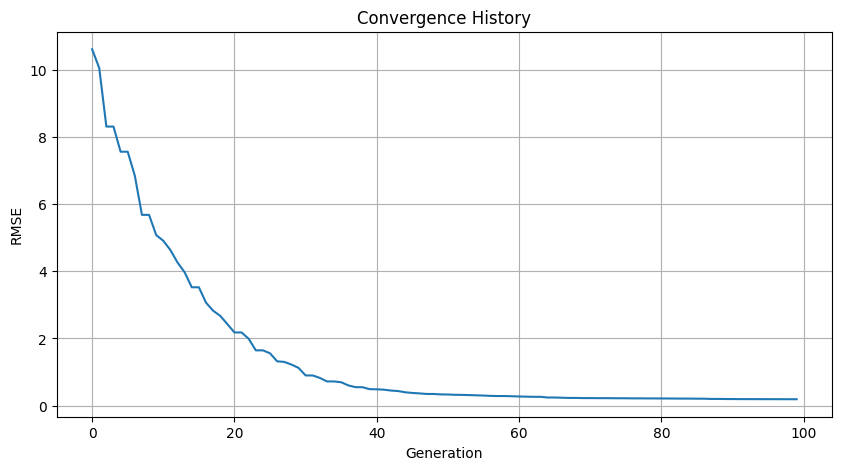

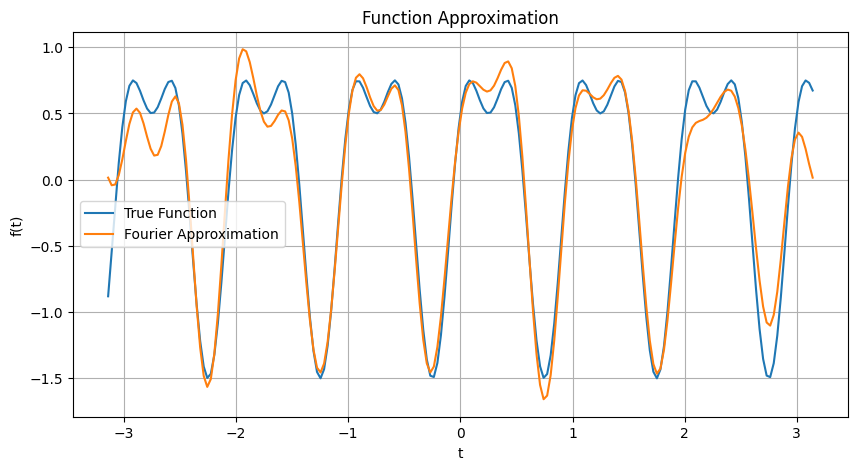

In [19]:
# algorithm parameters
numCoeffs = 20
populationSize = 100
generations = 100
mutationRate = 0.5
functionRange = (-np.pi, np.pi)
sampleCount = 200

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName="sin_cos")(tSamples)

# Run genetic algorithm
ga = Algorithm(tSamples, fSamples, numCoeffs, 5, populationSize, generations, mutationRate)
best_coeffs, cost_history = ga.Run(COtype="uniform",Stype="tournament",Mtype="random")

print("best coefficents achieved: ", best_coeffs)
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Convergence History")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Plot function approximation
approx = [Fourier(best_coeffs, t) for t in tSamples]
plt.figure(figsize=(10, 5))
plt.plot(tSamples, fSamples, label='True Function')
plt.plot(tSamples, approx, label='Fourier Approximation')
plt.title("Function Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()



**<span style="color:rgb(0, 211, 254);">[linear]</span>**

Generation 100/100
Best RMSE: 0.821765
best coefficents achieved:  [ 1.89907845e+00  8.06439349e-03 -9.52228134e-03  2.11828490e-02
 -3.54415701e-03 -4.97509220e-03 -2.72119211e-03  1.34207536e-02
 -4.20923976e-03  8.50910247e-04  9.09947974e-03 -4.03724283e-03
  1.01178248e-02  9.42948912e-03 -8.17862314e-04 -7.24529914e-03
  2.18959149e-02 -2.86567361e-03 -1.43865326e-04 -1.61955219e-02
  7.59591859e-03  4.05922853e+00 -2.07683708e+00  1.30314442e+00
 -8.78844147e-01  7.84533713e-01 -6.58284278e-01  5.12810099e-01
 -4.59187464e-01  4.15445543e-01 -3.88824170e-01  4.02570677e-01
 -3.22349045e-01  2.94184777e-01 -2.27765164e-01  2.10634523e-01
 -2.68972243e-01  2.29721645e-01 -1.98100518e-01 -2.24659519e-03
  5.78584225e-04]


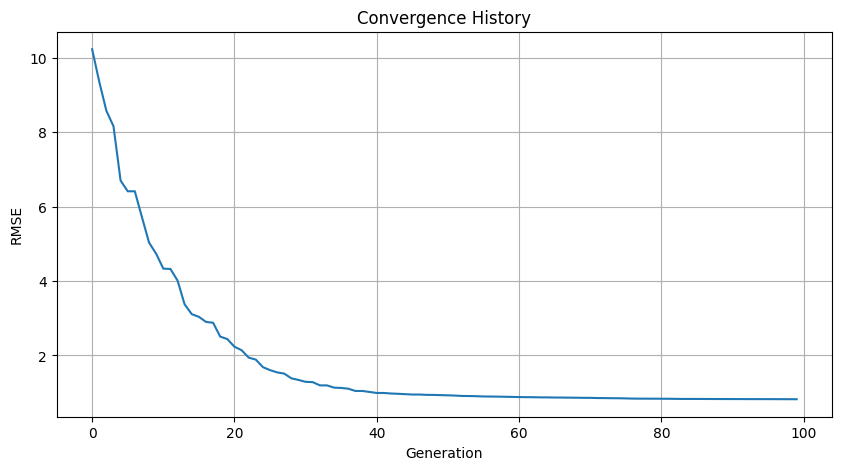

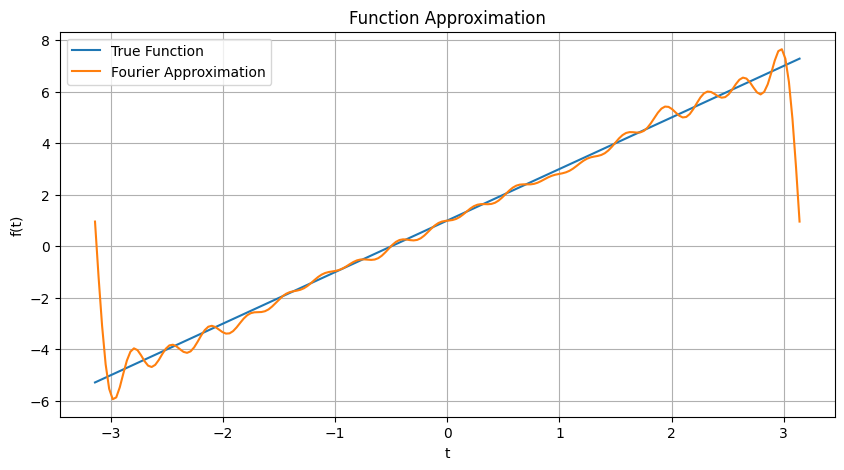

In [20]:
# algorithm parameters
numCoeffs = 20
populationSize = 100
generations = 100
mutationRate = 0.5
functionRange = (-np.pi, np.pi)
sampleCount = 200

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName="linear")(tSamples)

# Run genetic algorithm
ga = Algorithm(tSamples, fSamples, numCoeffs, 5, populationSize, generations, mutationRate)
best_coeffs, cost_history = ga.Run(COtype="uniform",Stype="tournament",Mtype="random")

print("best coefficents achieved: ", best_coeffs)
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Convergence History")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Plot function approximation
approx = [Fourier(best_coeffs, t) for t in tSamples]
plt.figure(figsize=(10, 5))
plt.plot(tSamples, fSamples, label='True Function')
plt.plot(tSamples, approx, label='Fourier Approximation')
plt.title("Function Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()



**<span style="color:rgb(0, 211, 254);">[quadratic]</span>**

Generation 100/100
Best RMSE: 1.973716
best coefficents achieved:  [ 2.97048830e+01 -1.57712301e+01  4.08705699e+00 -2.07116657e+00
  9.88515936e-01 -6.02158587e-01  5.45644963e-01 -3.65332573e-01
 -6.20657933e-03 -2.23078678e-01  1.43785143e-01 -1.38807572e-01
 -4.30461102e-02 -7.61687727e-02 -4.37582685e-02  4.43139503e-02
  2.11141473e-05  6.01084026e-03  5.52604036e-03 -4.80379598e-02
 -1.41873752e-02 -8.29109714e+00  3.81787645e+00 -2.60314616e+00
  1.83799056e+00 -1.72658678e+00  1.37968273e+00  8.29323303e-04
  1.00944710e+00 -9.75395484e-01  9.38658768e-01 -8.92358777e-01
  5.19337930e-01 -5.24071742e-01 -6.54198760e-03 -4.41277118e-01
 -4.00805847e-02 -1.48393825e-04  4.25417922e-01 -3.39706863e-01
  3.16470022e-01]


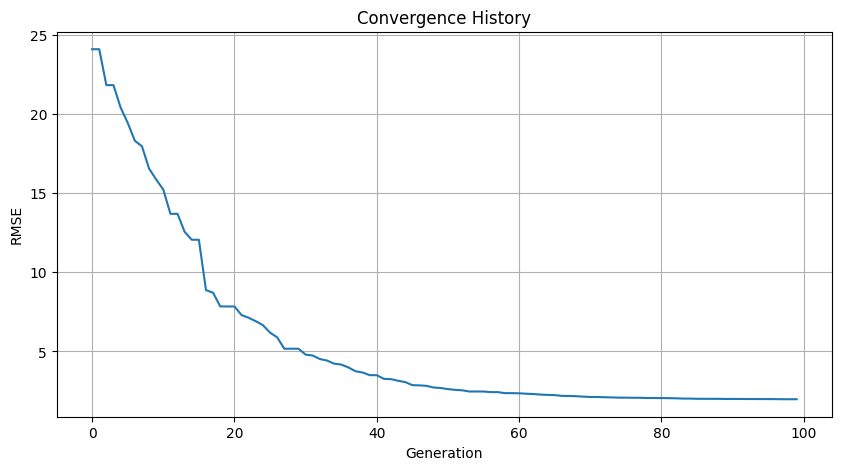

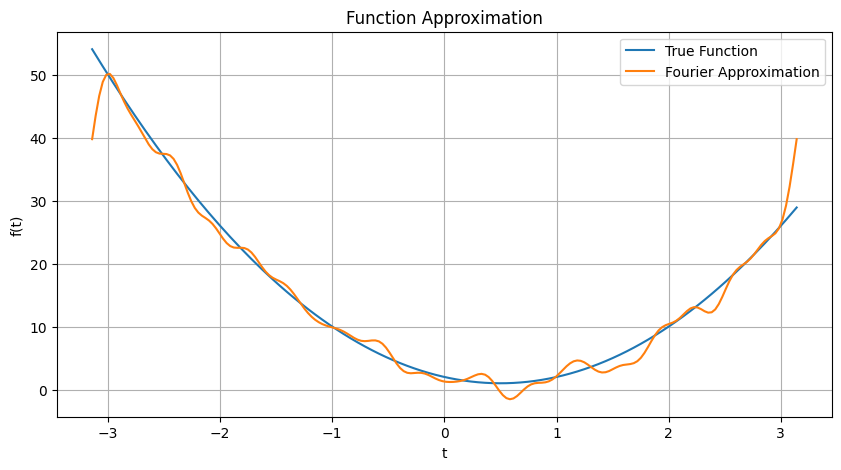

In [21]:
# algorithm parameters
numCoeffs = 20
populationSize = 100
generations = 100
mutationRate = 0.5
functionRange = (-np.pi, np.pi)
sampleCount = 200

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName="quadratic")(tSamples)

# Run genetic algorithm
ga = Algorithm(tSamples, fSamples, numCoeffs, 10, populationSize, generations, mutationRate)
best_coeffs, cost_history = ga.Run(COtype="uniform",Stype="tournament",Mtype="random")

print("best coefficents achieved: ", best_coeffs)
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Convergence History")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Plot function approximation
approx = [Fourier(best_coeffs, t) for t in tSamples]
plt.figure(figsize=(10, 5))
plt.plot(tSamples, fSamples, label='True Function')
plt.plot(tSamples, approx, label='Fourier Approximation')
plt.title("Function Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()



**<span style="color:rgb(0, 211, 254);">[cubic]</span>**

Generation 100/100
Best RMSE: 34.255841
best coefficents achieved:  [-8.25111167e+01  4.67636134e+01 -9.78421591e+00 -6.45076863e-03
  2.49543702e-02 -3.97467347e-02 -2.51547062e+00  3.12138799e-01
  2.64237322e-01 -1.17246487e-01 -8.54137070e-01 -1.72920901e-02
  2.82947273e-02  8.53451732e-02 -1.95129904e-01 -1.14939724e-01
 -2.24895484e+00 -2.67738309e-01 -2.49648366e+00  5.55969462e-02
 -1.58688070e-02  7.47717356e+01 -7.15189259e+01  4.82200978e+01
 -4.08909762e+01  3.57019031e+01 -2.69672783e+01  2.24776210e+01
 -2.06451217e+01  1.62258844e+01 -1.58855204e+01  1.25475809e+01
 -1.04529132e+01  1.25052411e+01 -1.16308413e+01  9.65499621e+00
 -8.33582822e+00  9.51953646e+00 -8.73872410e+00  8.36970882e+00
 -7.82144521e+00]


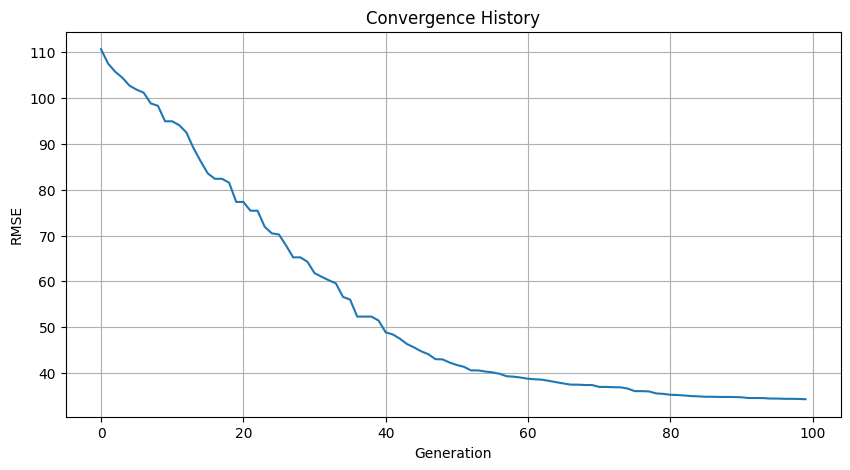

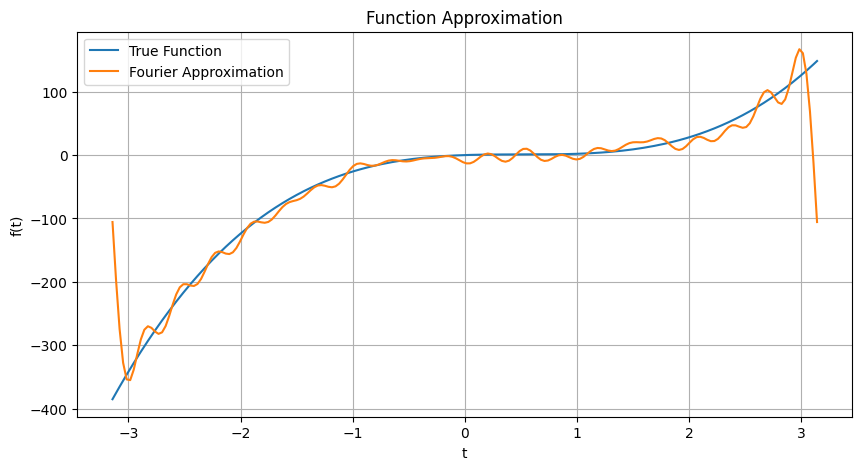

In [22]:
# algorithm parameters
numCoeffs = 20
populationSize = 100
generations = 100
mutationRate = 0.5
functionRange = (-np.pi, np.pi)
sampleCount = 200

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName="cubic")(tSamples)

# Run genetic algorithm
ga = Algorithm(tSamples, fSamples, numCoeffs, 10, populationSize, generations, mutationRate)
best_coeffs, cost_history = ga.Run(COtype="uniform",Stype="tournament",Mtype="random")

print("best coefficents achieved: ", best_coeffs)
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Convergence History")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Plot function approximation
approx = [Fourier(best_coeffs, t) for t in tSamples]
plt.figure(figsize=(10, 5))
plt.plot(tSamples, fSamples, label='True Function')
plt.plot(tSamples, approx, label='Fourier Approximation')
plt.title("Function Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()

**<span style="color:rgb(0, 211, 254);">[gaussian]</span>**

Generation 100/100
Best RMSE: 0.088690
best coefficents achieved:  [ 7.82990112e-02  7.05722083e-02  4.63837761e-02 -2.90202957e-04
 -2.56270664e-02  2.64531343e-05 -6.79101169e-02 -5.60549107e-02
 -3.33150081e-02 -1.53869657e-02 -6.01882765e-06 -4.07541243e-07
  3.82166675e-02  3.43364135e-02  2.30673207e-02  4.14816157e-03
  3.45743747e-05  1.67462786e-04 -1.27199800e-02 -1.48171673e-02
 -1.06619103e-02 -1.93569229e-04  6.10512162e-02  7.68933425e-02
 -3.43935418e-05  4.06230076e-02  5.62034042e-03 -2.00455594e-02
 -4.18957808e-02  2.75735096e-07  6.95312068e-05 -2.99302352e-02
 -6.40406684e-03  5.94641299e-03  2.35547086e-02  2.40677702e-02
  2.46270003e-02  1.66574760e-02 -6.60198161e-06  1.37668634e-03
 -3.76188229e-03]


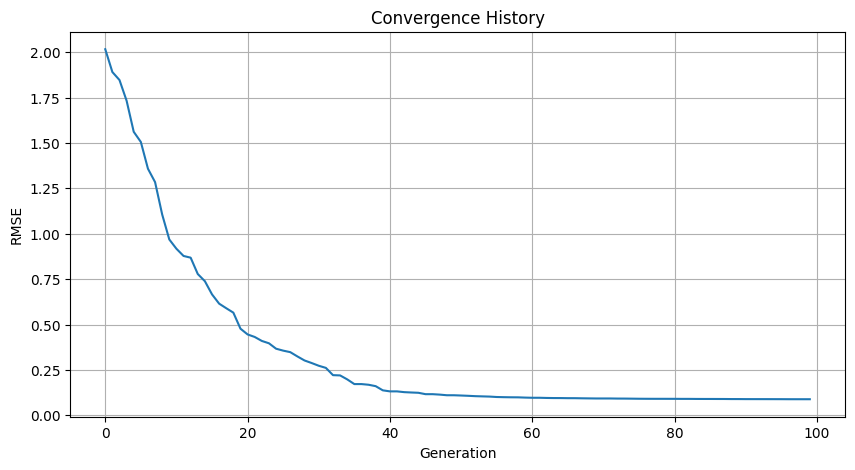

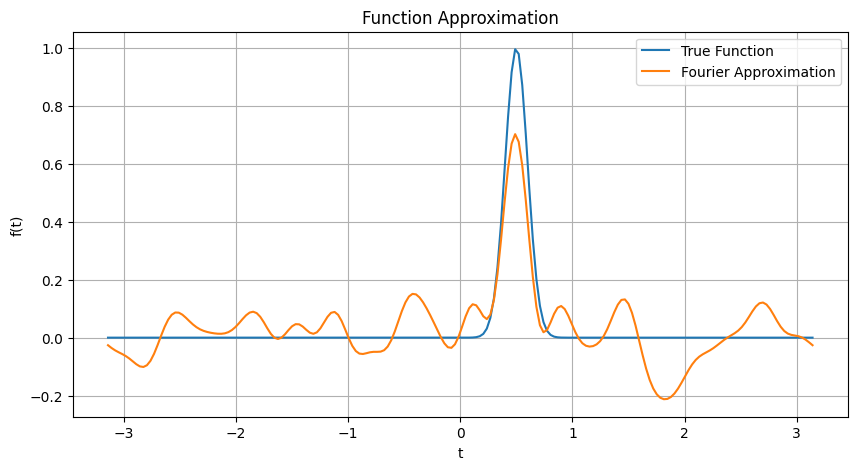

In [26]:
# algorithm parameters
numCoeffs = 20
populationSize = 100
generations = 100
mutationRate = 0.5
functionRange = (-np.pi, np.pi)
sampleCount = 200

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName="gaussian")(tSamples)

# Run genetic algorithm
ga = Algorithm(tSamples, fSamples, numCoeffs, 1, populationSize, generations, mutationRate)
best_coeffs, cost_history = ga.Run(COtype="uniform",Stype="tournament",Mtype="random")

print("best coefficents achieved: ", best_coeffs)
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Convergence History")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Plot function approximation
approx = [Fourier(best_coeffs, t) for t in tSamples]
plt.figure(figsize=(10, 5))
plt.plot(tSamples, fSamples, label='True Function')
plt.plot(tSamples, approx, label='Fourier Approximation')
plt.title("Function Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()

**<span style="color:rgb(0, 211, 254);">[square_wave]</span>**

Generation 100/100
Best RMSE: 0.183065
best coefficents achieved:  [ 9.74443685e-01  9.42188215e-04 -1.53351479e-03  1.61487138e-03
 -2.26003576e-04 -3.02078585e-03  7.69240474e-03 -9.57786572e-05
 -2.10290517e-03 -1.53176409e-03 -5.69938967e-03  4.06402565e-03
  7.36410096e-04 -3.64789573e-03 -2.16170962e-03 -2.43506938e-03
  4.79248407e-03 -5.61343037e-03  2.08247622e-03  1.11004225e-03
 -5.35241156e-03 -3.73814815e-03  1.97998721e-02 -4.59346329e-02
  5.39226014e-02 -9.05178896e-02  5.50529402e-01  2.06796804e-01
 -1.32014454e-01  7.18057645e-02 -3.00320383e-02 -1.30159265e-03
 -3.38323831e-02 -2.30435997e-04 -2.23320722e-02 -2.30390912e-04
 -1.13797499e-02 -9.15039775e-04  1.99657134e-02  2.15975526e-01
  4.15438221e-04]


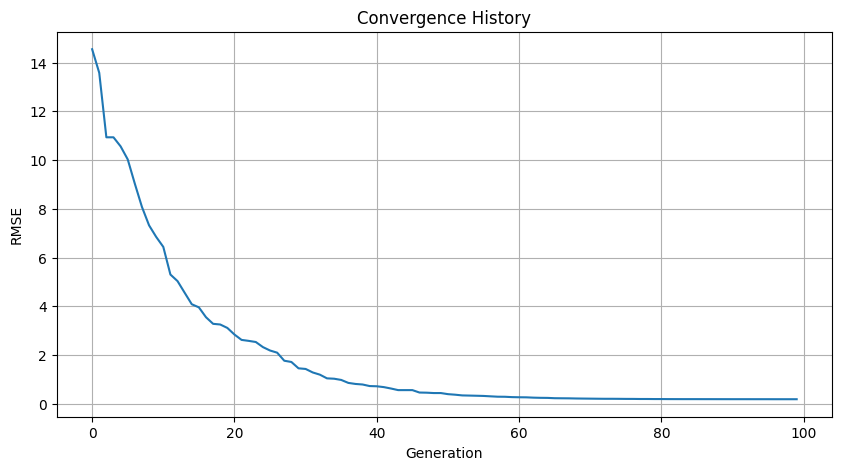

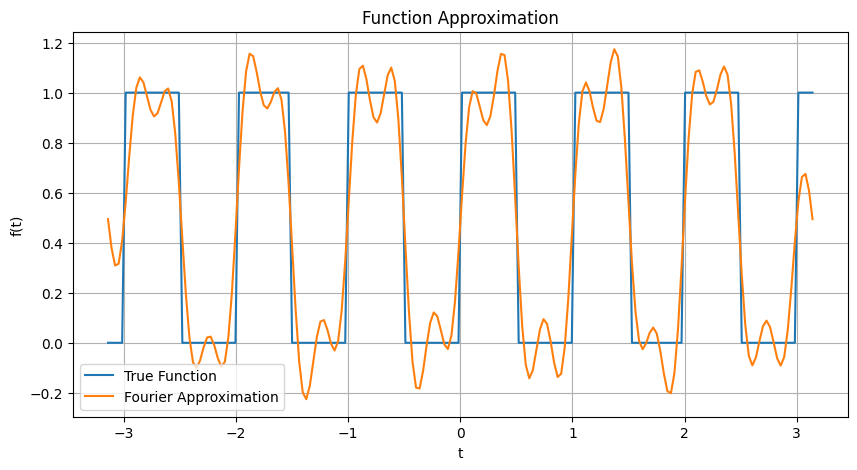

In [51]:
# algorithm parameters
numCoeffs = 20
populationSize = 100
generations = 100
mutationRate = 0.5
functionRange = (-np.pi, np.pi)
sampleCount = 200

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName="square_wave")(tSamples)

# Run genetic algorithm
ga = Algorithm(tSamples, fSamples, numCoeffs, 8, populationSize, generations, mutationRate)
best_coeffs, cost_history = ga.Run(COtype="uniform",Stype="tournament",Mtype="random")

print("best coefficents achieved: ", best_coeffs)
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Convergence History")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Plot function approximation
approx = [Fourier(best_coeffs, t) for t in tSamples]
plt.figure(figsize=(10, 5))
plt.plot(tSamples, fSamples, label='True Function')
plt.plot(tSamples, approx, label='Fourier Approximation')
plt.title("Function Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()



**<span style="color:rgb(0, 211, 254);">[sawtooth]</span>**

Generation 100/100
Best RMSE: 0.220062
best coefficents achieved:  [ 1.06626773e+00  3.11497972e-03  3.32014466e-02  3.03941451e-02
  2.67911395e-02 -1.10139357e-03  1.38233138e-03 -2.05298380e-02
  2.48858209e-02 -2.56944651e-03 -4.61896099e-03  2.09354550e-02
  2.90130926e-03 -1.44093224e-03 -8.96973300e-03  3.77978088e-03
 -3.18865267e-02  2.15591510e-02  1.54546936e-04  1.39606201e-02
  1.56318055e-02  8.06370793e-03  6.39790997e-05  3.27266931e-02
 -3.13095025e-03 -1.30096365e-02 -4.61746808e-03  5.51205377e-03
  1.08980356e-03 -1.89040561e-02 -1.82223011e-02 -3.10706109e-02
 -8.95550165e-04  2.83441001e-03 -8.08162516e-03 -2.89926617e-03
 -3.66564674e-03  2.09917157e-03 -8.62896551e-03  1.18159789e-03
 -6.17885742e-03 -3.31841831e-02  1.78803504e-04 -1.97283786e-02
  2.73379738e-03 -1.03023847e-02 -2.09554008e-02  9.88436992e-03
  1.47655138e-02 -4.51723698e-03 -8.64591957e-04 -3.06378717e-02
  7.42067484e-03 -1.22149018e-02 -5.48340277e-02 -6.78652442e-03
  1.22087739e-02  4.708

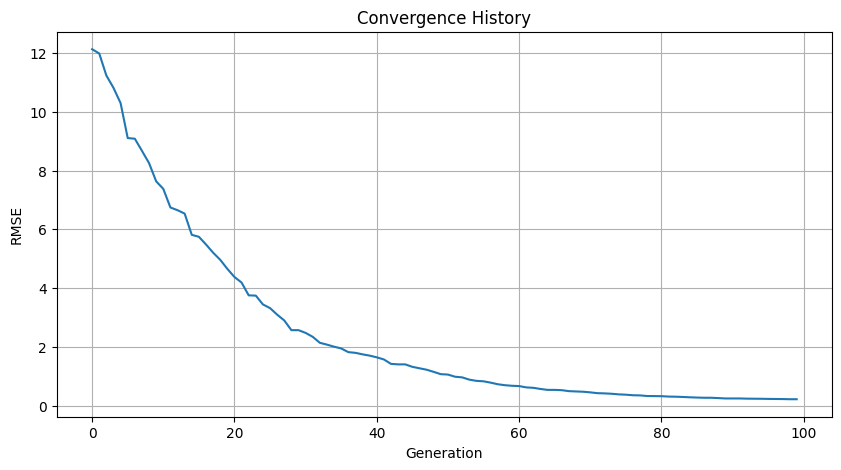

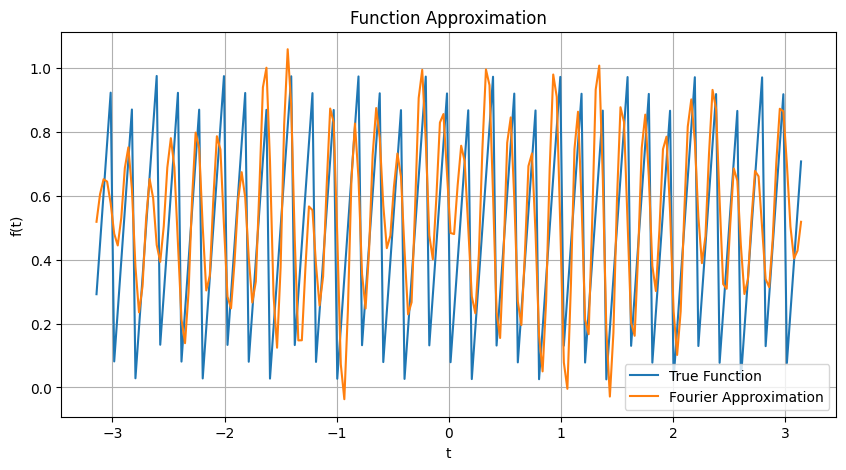

In [48]:
# algorithm parameters
numCoeffs = 41
populationSize = 100
generations = 100
mutationRate = 0.8
functionRange = (-np.pi, np.pi)
sampleCount = 200

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName="sawtooth")(tSamples)

# Run genetic algorithm
ga = Algorithm(tSamples, fSamples, numCoeffs, 4, populationSize, generations, mutationRate)
best_coeffs, cost_history = ga.Run(COtype="uniform",Stype="tournament",Mtype="random")

print("best coefficents achieved: ", best_coeffs)
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Convergence History")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Plot function approximation
approx = [Fourier(best_coeffs, t) for t in tSamples]
plt.figure(figsize=(10, 5))
plt.plot(tSamples, fSamples, label='True Function')
plt.plot(tSamples, approx, label='Fourier Approximation')
plt.title("Function Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()

Generation 100/100
Best RMSE: 0.284227
best coefficents achieved:  [ 9.91425714e-01  6.76961872e-05 -7.06688043e-04  3.09149740e-05
 -2.42979110e-05  2.50784256e-05 -5.69883239e-04 -7.14443187e-04
 -5.09138005e-05  1.52895828e-04  2.89114998e-05 -1.41272640e-04
  8.95479052e-06  1.12689791e-04 -2.73579971e-04 -3.05409118e-04
 -3.03505435e-04 -3.11641132e-04  1.12087184e-03 -5.93532419e-04
 -4.21020220e-04  3.42440922e-05  1.22518724e-03 -2.68914829e-04
  1.48118823e-04  5.04918656e-04 -1.82163221e-03  1.82047963e-03
 -3.81901499e-03  9.69267202e-03  3.11090491e-08 -4.10109024e-02
 -1.90815287e-05  2.48448015e-05  1.04465435e-02  1.47882868e-04
  9.61679674e-03 -9.71629120e-03 -3.85551243e-05 -1.16931123e-02
  1.15521286e-02]


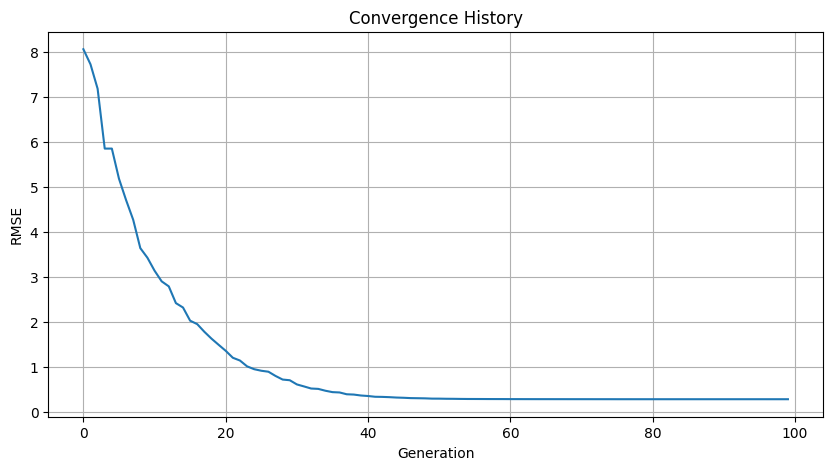

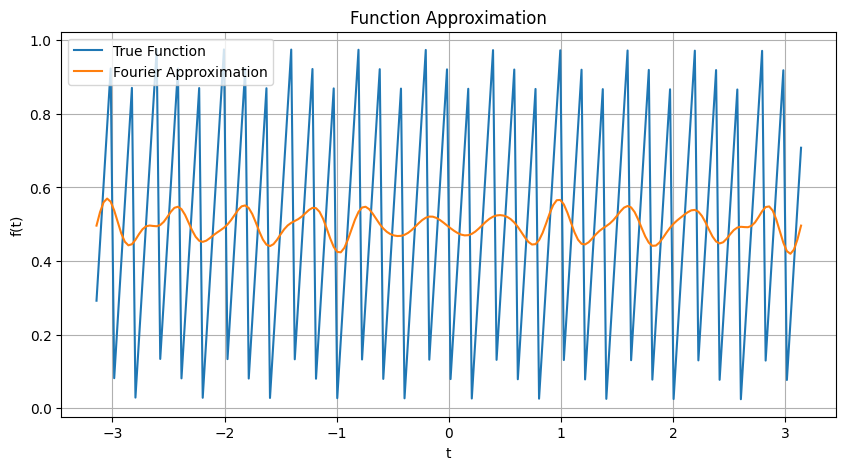

In [49]:
# algorithm parameters
numCoeffs = 20
populationSize = 100
generations = 100
mutationRate = 0.8
functionRange = (-np.pi, np.pi)
sampleCount = 200

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName="sawtooth")(tSamples)

# Run genetic algorithm
ga = Algorithm(tSamples, fSamples, numCoeffs, 4, populationSize, generations, mutationRate)
best_coeffs, cost_history = ga.Run(COtype="uniform",Stype="tournament",Mtype="random")

print("best coefficents achieved: ", best_coeffs)
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Convergence History")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Plot function approximation
approx = [Fourier(best_coeffs, t) for t in tSamples]
plt.figure(figsize=(10, 5))
plt.plot(tSamples, fSamples, label='True Function')
plt.plot(tSamples, approx, label='Fourier Approximation')
plt.title("Function Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()

**<span style="color:rgb(0, 211, 254);">[complex_fourier]</span>**

Generation 100/100
Best RMSE: 0.213290
best coefficents achieved:  [-1.02688320e-02  2.84157508e-04 -1.96941784e-03  1.18678973e-03
  1.55611655e-02 -7.94715004e-03 -7.39784937e-04  6.34720852e-04
 -6.95653745e-04 -3.37248553e-02 -2.18498948e-05  4.29227799e-06
  1.60425158e-01  2.13689571e-01 -6.69916808e-02 -1.70871155e-04
 -1.83062022e-02  1.87529380e-02  7.36719479e-04 -6.83906668e-04
  1.84944482e-03  2.73677646e-04  2.94555563e-02 -5.43959762e-02
  8.61450646e-02 -1.70068660e-01  8.29917688e-01  3.56379681e-01
  1.63697769e-04 -5.31878646e-07 -8.76735462e-02 -3.17468628e-05
 -5.41731175e-02  4.28969891e-02 -4.34510884e-02 -2.77143973e-05
 -8.99061801e-03  2.54059700e-02  4.54291810e-03  2.09553258e-01
 -4.16944466e-02]


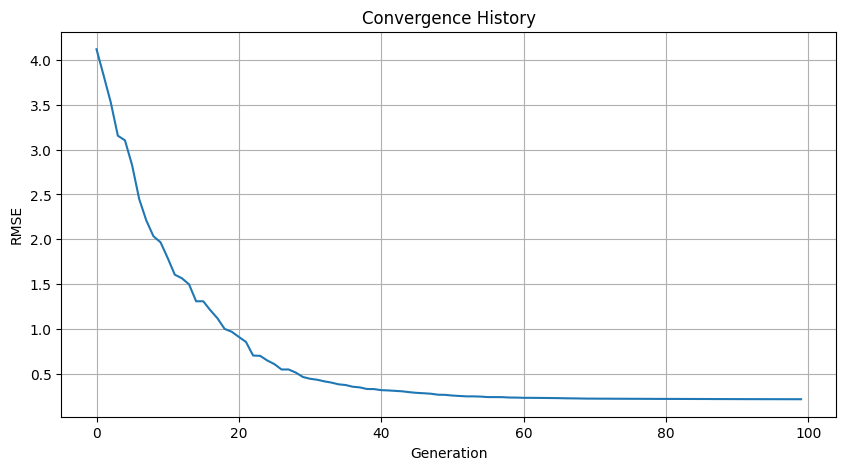

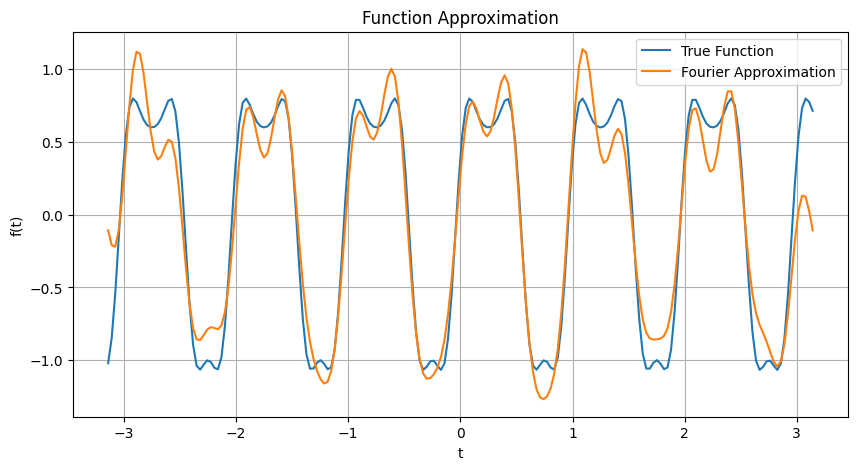

In [29]:
# algorithm parameters
numCoeffs = 20
populationSize = 100
generations = 100
mutationRate = 0.5
functionRange = (-np.pi, np.pi)
sampleCount = 200

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName="complex_fourier")(tSamples)

# Run genetic algorithm
ga = Algorithm(tSamples, fSamples, numCoeffs, 2, populationSize, generations, mutationRate)
best_coeffs, cost_history = ga.Run(COtype="uniform",Stype="tournament",Mtype="random")

print("best coefficents achieved: ", best_coeffs)
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Convergence History")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Plot function approximation
approx = [Fourier(best_coeffs, t) for t in tSamples]
plt.figure(figsize=(10, 5))
plt.plot(tSamples, fSamples, label='True Function')
plt.plot(tSamples, approx, label='Fourier Approximation')
plt.title("Function Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()

**<span style="color:rgb(0, 211, 254);">[polynomial]</span>**

Generation 100/100
Best RMSE: 448.755919
best coefficents achieved:  [-7.49698469e+02  6.32329168e+02 -3.48648973e+02  1.57775946e+02
 -9.97127978e+01  3.55613277e+01 -4.94106586e+01  4.59532011e+01
 -4.74417803e+01 -5.06124924e+00 -2.61237334e+01 -1.22572451e-01
  2.35803033e-01  7.81810243e-01  6.21634043e-01  1.23168332e+01
  3.92737444e+00 -4.33358911e+00 -2.17270141e+01  8.56048135e+00
  8.88723658e+00  5.27146649e+02 -6.47913486e+02  5.69032823e+02
 -5.30672760e+02  3.85430928e+02 -3.72858563e+02  3.06131200e+02
 -2.31720575e+02  2.37521940e+02 -2.18831823e+02  2.07975398e+02
 -2.01187390e+02  1.44178510e+02 -1.24778488e+02  1.48887973e+02
 -9.39641995e+01  1.07050113e+02 -1.09694906e+02  1.08872482e+02
 -7.80732148e+01]


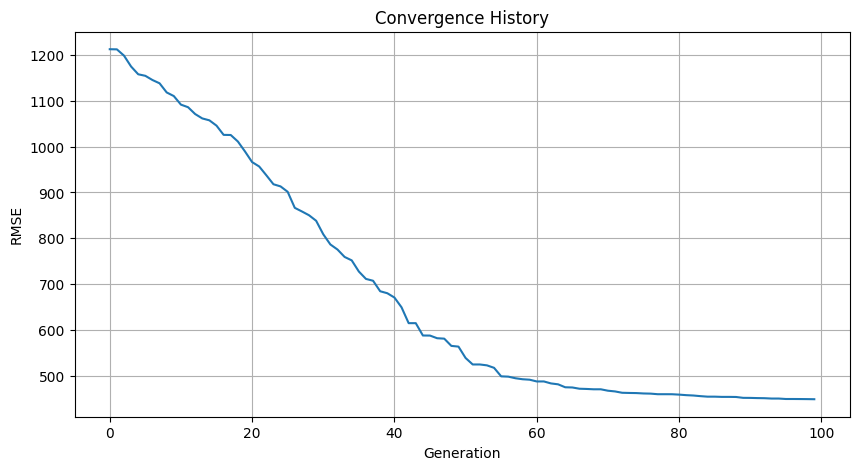

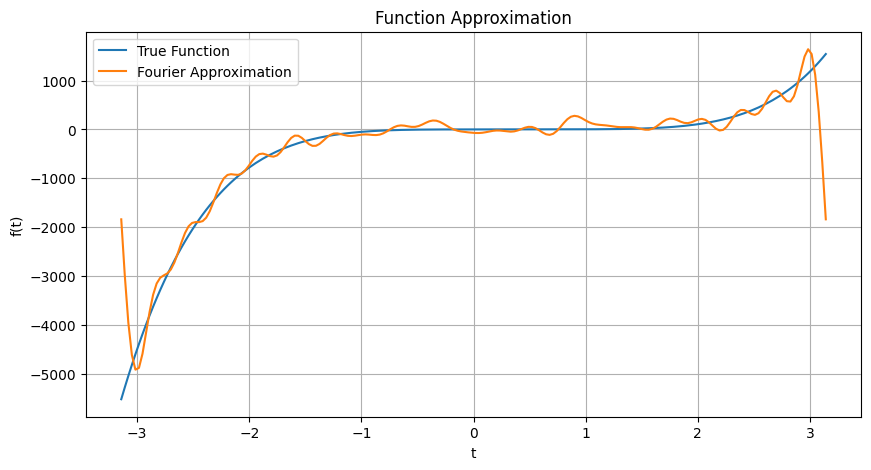

In [36]:
# algorithm parameters
numCoeffs = 20
populationSize = 100
generations = 100
mutationRate = 0.5
functionRange = (-np.pi, np.pi)
sampleCount = 200

# Generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction(functionName="polynomial")(tSamples)

# Run genetic algorithm
ga = Algorithm(tSamples, fSamples, numCoeffs, 100, populationSize, generations, mutationRate)
best_coeffs, cost_history = ga.Run(COtype="uniform",Stype="tournament",Mtype="random")

print("best coefficents achieved: ", best_coeffs)
# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Convergence History")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Plot function approximation
approx = [Fourier(best_coeffs, t) for t in tSamples]
plt.figure(figsize=(10, 5))
plt.plot(tSamples, fSamples, label='True Function')
plt.plot(tSamples, approx, label='Fourier Approximation')
plt.title("Function Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend()
plt.grid(True)
plt.show()



#### **<span style="color:rgb(223, 9, 84);">[Questions]</span>**


**<span style="color:rgb(255, 0, 0);">[Question 1:]</span>**

For a chromosome representing Fourier coefficients with 41 coefficients (a₀ + 20 aₙ + 20 bₙ), Each coefficient bounded within [-A, A] (e.g., A=10) and because its continious, it has very large domain.

**<span style="color:rgb(255, 255, 0);">[Question 2:]</span>**

1. **get mean of two parents in Crossover**: it produce a child that its coefficients is exatly mean of its parent coefficients. After a few generations, all the offspring produced, which are the average of the coefficients of their parents, will have their coefficients unintentionally tending to a single number. That number is probably 0, i.e. the middle of the interval [-A,A].

2. **select best of coefficient generated and pass them to next generation**:


**<span style="color:rgb(0, 255, 0);">[Question 3:]</span>**

1. We can pass the offspring produced in the current generation to the next generation, which is what is done in this implementation.

2. We can select the best of the current generation and the offspring produced and consider populationSize of the best of them as the next generation.

**<span style="color:rgb(0, 255, 255);">[Question 4:]</span>**

1. **Using Mutation:** One of the goals of the mutation function is to make a change in a gene, resulting in the generation of a new gene that behaves differently from the previous gene. This process slows down the convergence of the algorithm.

2. **Using Random ways:** Usually, elitism in genetic algorithms leads to rapid convergence of the algorithm, for example, we observed that rank-based selection and roulette, which are both based on elitism, meaning that better odds have more chances. And this caused us to quickly get stuck in a local optimum, which caused the algorithm to crash.

**<span style="color:rgb(255, 0, 255);">[Question 5:]</span>**

**Definition**
The R-squared (R²) metric is calculated as:

$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$

Where:
- $y_i$ = Actual function values
- $\hat{y}_i$ = Predicted values from Fourier approximation
- $\bar{y}$ = Mean of actual values
- $n$ = Number of sample points

**Interpretation**
- Ranges from 0 to 1 (higher is better)
- Represents proportion of variance in dependent variable that's predictable from the independent variables
- 1 = Perfect prediction
- 0 = No better than mean prediction


Advantages

    "Normalized scale (0-1) allows comparison across different target functions",
    "Intuitive interpretation as 'percentage of variance explained'",
    "Naturally penalizes both over- and under-fitting",
    "Useful for comparing models with different numbers of coefficients"

**yes, with help if this, we can have information about the population variance, And is the population stagnating? That is, stuck in a local optimum? And how similar are the populations?**